# Preparing the Data

In [11]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import geobr
import os
import scipy.stats as stats

In [12]:
import os

# Construct the relative file path
file_path = os.path.join('Data', 'Data_Amazonia.txt')

try:
  df = pd.read_csv(file_path, sep='\t')  # Assuming tab-separated values
  print(df.head())  # Print the first few rows of the DataFrame
except FileNotFoundError:
  print(f"File not found at: {file_path}")
except pd.errors.ParserError:
  print(f"Error parsing the file at: {file_path}. Check the file format.")

   vec_Munic  vec_Month  vec_Area  vec_FS  vec_LUT  vec_Prec   vec_Temp  \
1    1500107          1  1610.652       3    1.078  0.550538  26.316667   
2    1500131          1   614.131       0    0.250  0.365905  25.543264   
3    2100055          1  5808.304       4    4.570  0.328655  25.737003   
4    1500206          1  4344.384       6    4.300  0.397751  26.066881   
5    1200013          1  1807.953       0    1.230  0.573202  24.771592   

   vec_Humid  vec_Speed  
1  81.385753   0.909005  
2  79.016691   1.386955  
3  77.551571   1.549899  
4  79.872620   1.200555  
5  87.530914   0.958162  


In [13]:
# Funktion zum Bootstrappen
def bootstrap(data, n_bootstrap, n_samples,statistic):
    """
    Führt Bootstrapping durch, um eine beliebige Statistik zu approximieren.

    Parameters:
    - data: array-like, die Originaldaten.
    - n_bootstrap: int, Anzahl der Bootstrap-Wiederholungen.
    - n_samples: int, Anzahl der Datenpunkte pro Stichprobe.
    - statistic: callable, die Statistik, die berechnet werden soll (z. B. np.mean, np.median).

    Returns:
    - boot_stats: np.array, die berechneten Werte der Statistik für jede Bootstrap-Stichprobe.
    """

    boot_means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=n_samples, replace=True)
        boot_means.append(statistic(sample))
    return np.array(boot_means)

In [14]:
# Assuming 'vec_Munic' is a column in your DataFrame 'df'
num_unique_municipals = len(df['vec_Munic'].unique())
print(f"Number of unique municipalities in 'vec_Munic': {num_unique_municipals}")

Number of unique municipalities in 'vec_Munic': 558


In [15]:
df_sorted = df.sort_values(by=['vec_Month',"vec_Munic"])

n_bootstrap = 1000  # Example number of bootstrap iterations
n_samples = 558 # Example number of samples per bootstrap iteration

columns_to_bootstrap = ['vec_FS', 'vec_Prec', 'vec_Temp', 'vec_Humid', 'vec_Speed']
bootstrap_means = {}

for column in columns_to_bootstrap:
  bootstrap_means[column] = []

for month in range(1, 121):  # Iterate through months 1 to 120
  for col in columns_to_bootstrap:
      # Filter data for the current month.
      monthly_data = df_sorted[df_sorted['vec_Month'] == month][col].values

      if len(monthly_data) > 0:  #Check if data exist for the month
          # Apply bootstrap with mean statistic.
          means = bootstrap(monthly_data, n_bootstrap, min(n_samples, len(monthly_data)), np.mean)
          bootstrap_means[col].append(means) #Append all bootstrap means for the specific month
      else:
          # Handle cases with no data for a particular month
          bootstrap_means[col].append(np.nan) # or another suitable value like 0
          print(f"No data available for month {month} and column {col}")

# Convert the dictionary of lists into a dictionary of NumPy arrays
for col in columns_to_bootstrap:
    bootstrap_means[col] = np.array(bootstrap_means[col])

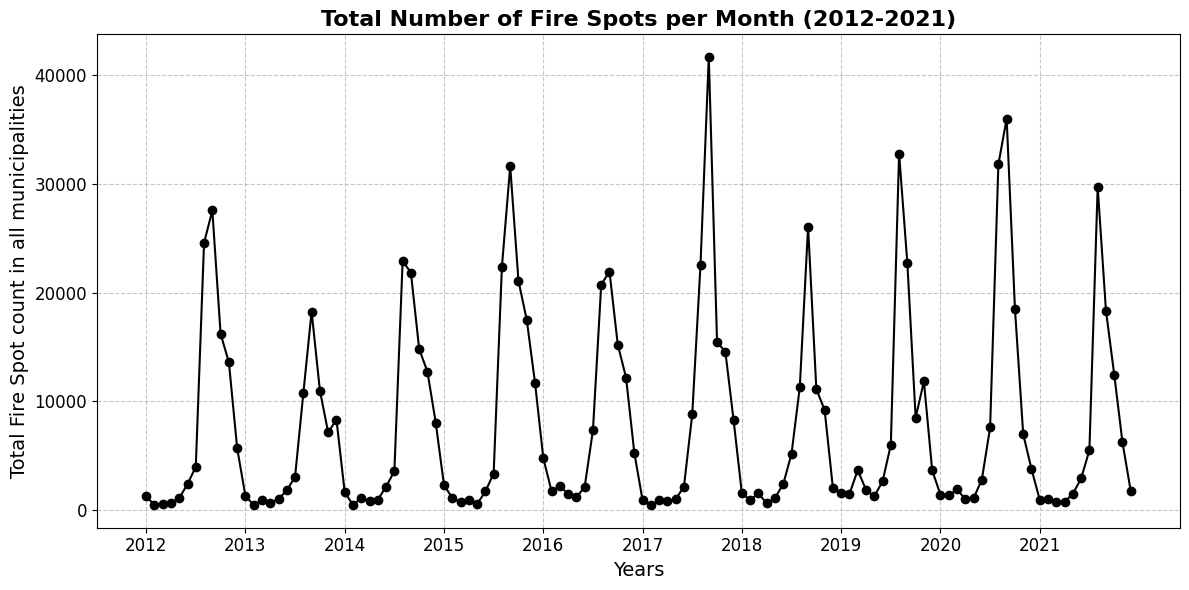

In [16]:
# Group the data by 'vec_Month' and sum the values
df_sorted_1 = df.groupby("vec_Month").sum()

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(df_sorted_1["vec_FS"], marker='o', linestyle='-', color='black')

# Add labels and title
plt.xlabel('Years', fontsize=14)
plt.ylabel('Total Fire Spot count in all municipalities', fontsize=14)
plt.title('Total Number of Fire Spots per Month (2012-2021)', fontsize=16, fontweight='bold')

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.7)

# Customize the x-axis ticks to show the years for each month
months = range(1, 121)  # Total of 120 months (10 years)
years = [f'{2012 + (month - 1) // 12}' for month in months]  # Create year labels for each month
plt.xticks(ticks=range(1, 121, 12), labels=[f'{year}' for year in years[::12]], fontsize=12)  # Label each year

# Customize the y-axis ticks
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

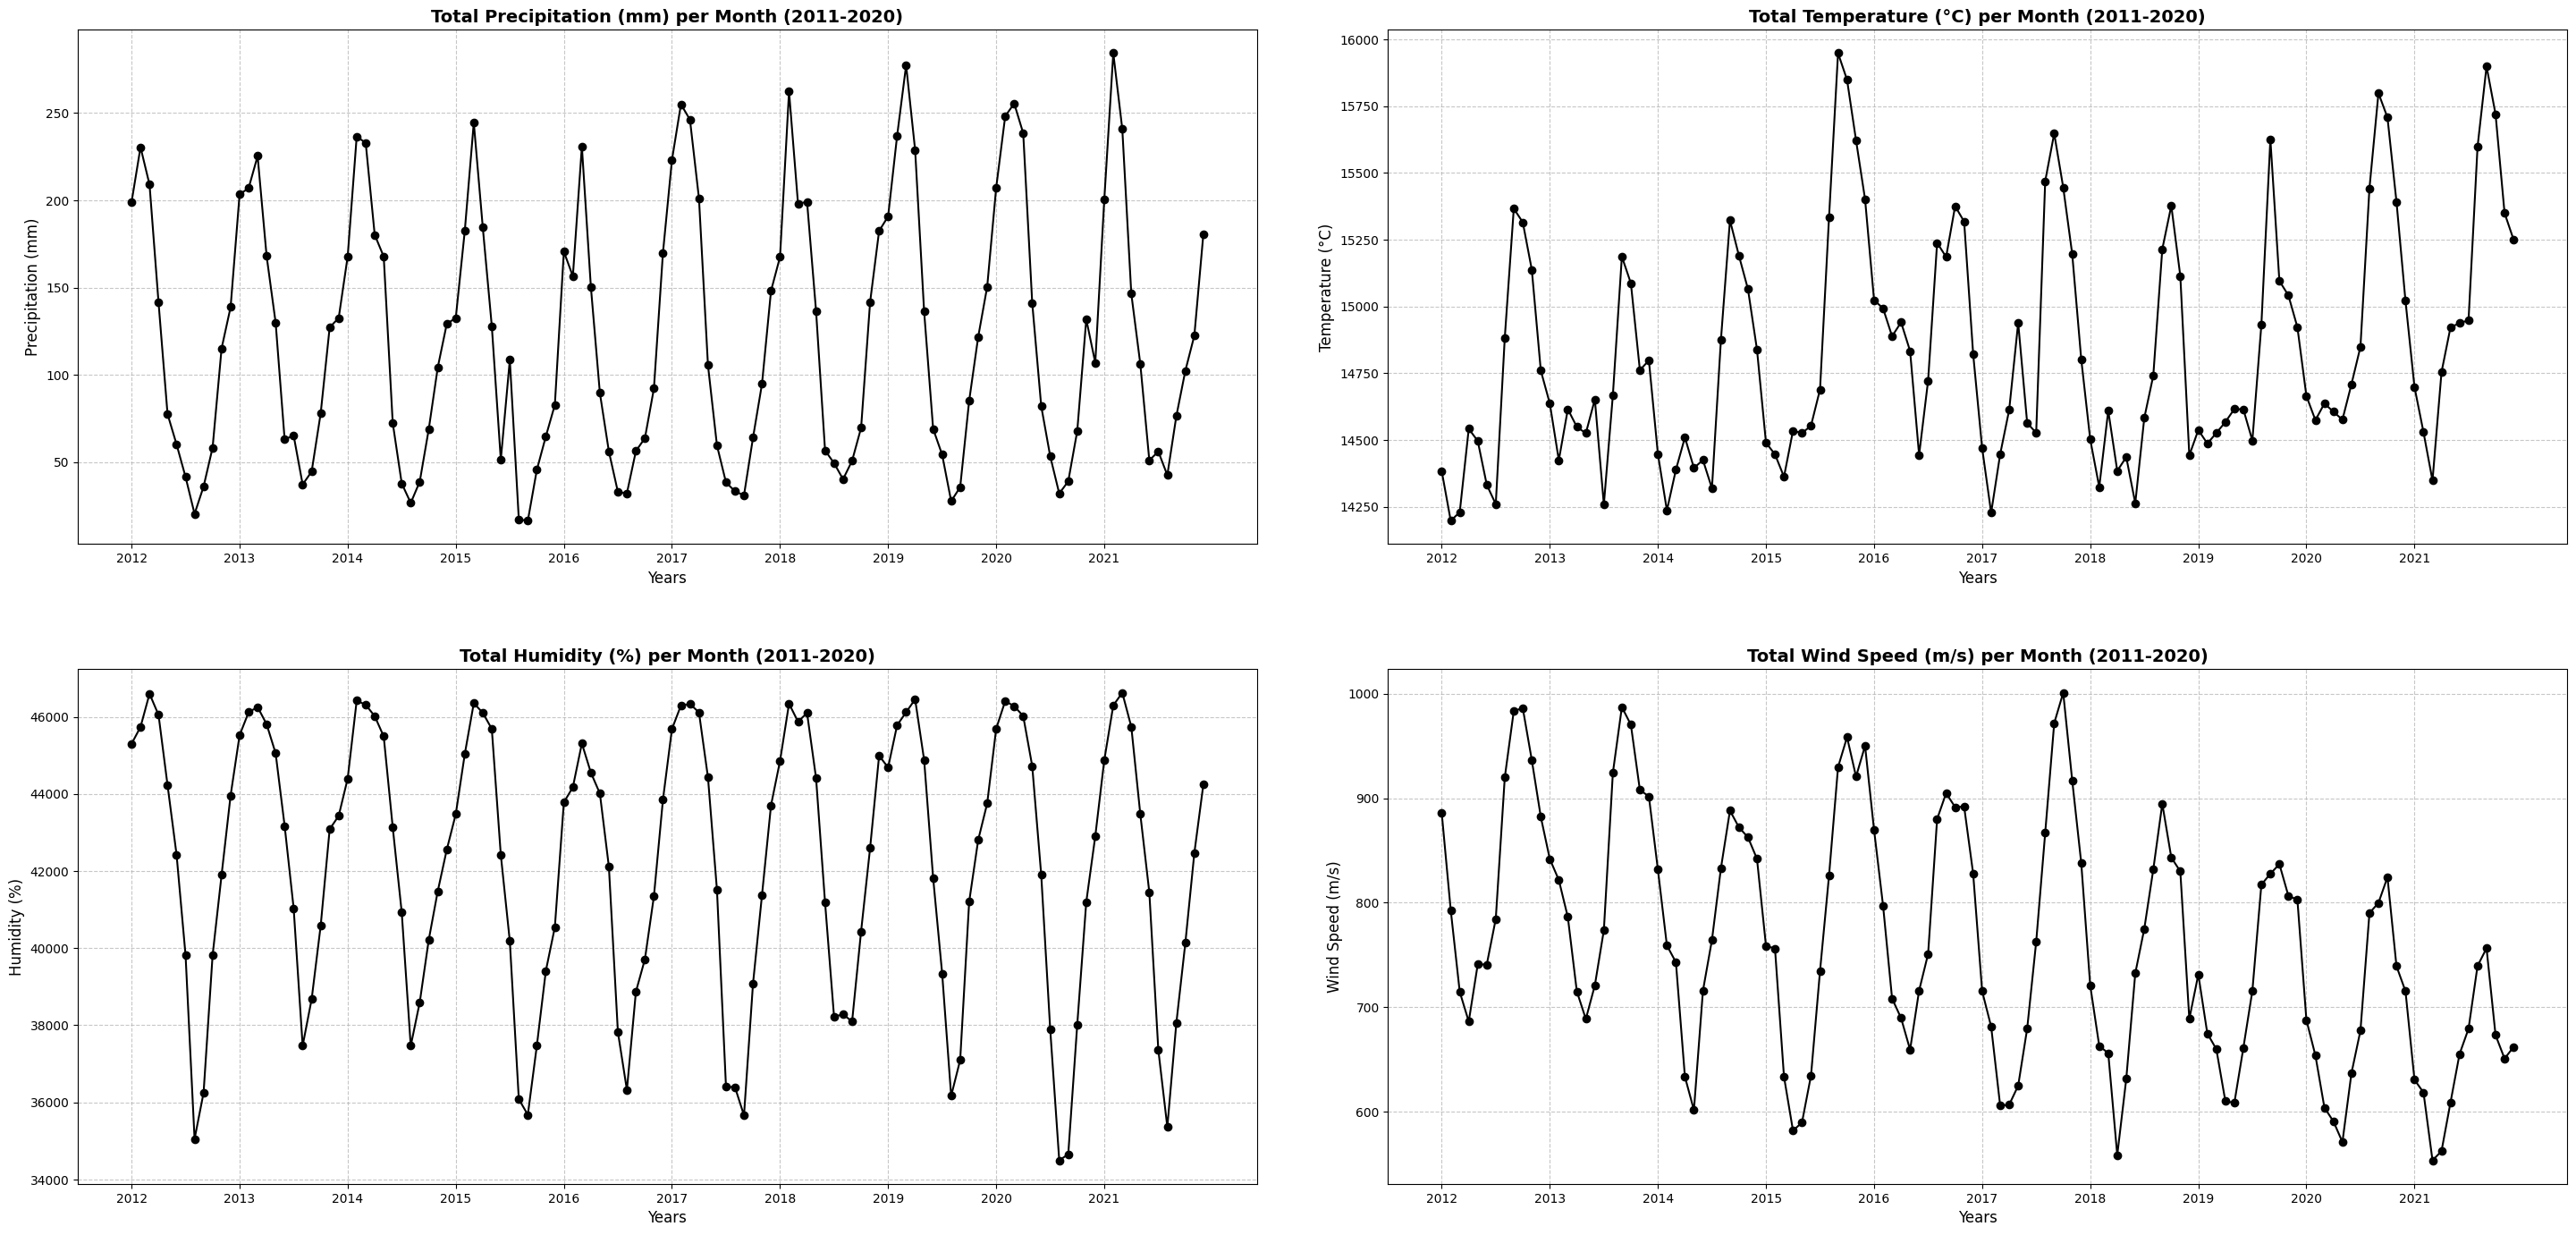

In [17]:
# Define the columns to plot
columns = ['vec_FS', 'vec_Prec', 'vec_Temp', 'vec_Humid', 'vec_Speed']
labels = ['Total Fire Spot count', 'Precipitation (mm)', 'Temperature (°C)', 'Humidity (%)', 'Wind Speed (m/s)']

# Create a figure with 4 subplots (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(30, 15))

# Loop through the columns to plot each one
for i, column in enumerate(columns[1:]):
    # Group the data by 'vec_Month' and sum the values
    df_sorted_1 = df.groupby("vec_Month").sum()
    
    # Plot on the corresponding subplot
    ax = axes[i // 2, i % 2]
    ax.plot(df_sorted_1[column], marker='o', linestyle='-', color='black')

    # Set the title and labels
    ax.set_xlabel('Years', fontsize=12)
    ax.set_ylabel(labels[i + 1], fontsize=12)
    ax.set_title(f'Total {labels[i + 1]} per Month (2011-2020)', fontsize=14, fontweight='bold')

    # Add grid lines
    ax.grid(True, linestyle='--', alpha=0.7)

    # Customize the x-axis ticks to show the years for each month
    months = range(1, 121)  # Total of 120 months (10 years)
    years = [f'{2012 + (month - 1) // 12}' for month in months]  # Create year labels for each month
    ax.set_xticks(range(1, 121, 12))
    ax.set_xticklabels([f'{year}' for year in years[::12]], fontsize=10)

    # Customize the y-axis ticks
    ax.tick_params(axis='y', labelsize=10)

# Adjust layout to prevent overlap and leave more room between subplots
plt.tight_layout(pad=5.0)

# Show the plot
plt.show()

In [ ]:
# Group the DataFrame by municipality and calculate the average of vec_FS
average_fs_by_municipality = df.groupby('vec_Munic')['vec_FS'].mean().reset_index()
average_fs_by_municipality.columns = ['code_muni', 'avg_FS']

# Load geospatial data
gdf_municipalities = geobr.read_municipality(year=2020)

# Merge with municipality geodata
gdf_filtered_municipalities = gdf_municipalities[gdf_municipalities['code_muni'].isin(average_fs_by_municipality['code_muni'])]
gdf_filtered_municipalities = gdf_filtered_municipalities.merge(average_fs_by_municipality, on='code_muni')

# Create the plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot municipalities, coloring them by avg_FS
gdf_filtered_municipalities.plot(ax=ax, column='avg_FS', cmap='YlOrRd', legend=True, edgecolor='darkgray')

# Add title and labels
ax.set_title('Unique Municipalities Colored by Average Fire Spots (10-Year Period)', fontsize=15)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Remove axis
ax.axis('off')


# Save the plot as an SVG file
plt.savefig('Unique_Municipalities.svg', format='svg', bbox_inches='tight', transparent=True)


# Show the plot
plt.show()

In [20]:
# Group the DataFrame by municipality and calculate the average of vec_FS
average_fs_by_municipality = df.groupby('vec_Munic')['vec_FS'].mean().reset_index()
average_fs_by_municipality.columns = ['code_muni', 'avg_FS']

# Load geospatial data
gdf_municipalities = geobr.read_municipality(year=2020)
gdf_states = geobr.read_state(year=2020)

# Merge with municipality geodata
gdf_filtered_municipalities = gdf_municipalities[gdf_municipalities['code_muni'].isin(average_fs_by_municipality['code_muni'])]
gdf_filtered_municipalities = gdf_filtered_municipalities.merge(average_fs_by_municipality, on='code_muni')

# Create the plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot all states
gdf_states.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.8)

# Plot all municipalities in Brazil with light gray color
gdf_municipalities.plot(ax=ax, edgecolor='darkgray', facecolor='lightgray', linewidth=0.5)

# Highlight the unique municipalities in the DataFrame
gdf_filtered_municipalities.plot(ax=ax, edgecolor='black', facecolor='darkseagreen', linewidth=0.8)

# Remove axis
ax.axis('off')

# Save the plot as an SVG file
plt.savefig('highlighted_municipalities.svg', format='svg', bbox_inches='tight', transparent=True)

# Show the plot
plt.show()

"# Group the DataFrame by municipality and calculate the average of vec_FS\naverage_fs_by_municipality = df.groupby('vec_Munic')['vec_FS'].mean().reset_index()\naverage_fs_by_municipality.columns = ['code_muni', 'avg_FS']\n\n# Load geospatial data\ngdf_municipalities = geobr.read_municipality(year=2020)\ngdf_states = geobr.read_state(year=2020)\n\n# Merge with municipality geodata\ngdf_filtered_municipalities = gdf_municipalities[gdf_municipalities['code_muni'].isin(average_fs_by_municipality['code_muni'])]\ngdf_filtered_municipalities = gdf_filtered_municipalities.merge(average_fs_by_municipality, on='code_muni')\n\n# Create the plot\nfig, ax = plt.subplots(figsize=(12, 12))\n\n# Plot all states\ngdf_states.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.8)\n\n# Plot all municipalities in Brazil with light gray color\ngdf_municipalities.plot(ax=ax, edgecolor='darkgray', facecolor='lightgray', linewidth=0.5)\n\n# Highlight the unique municipalities in the DataFrame\ngdf_fi

# Data for one year

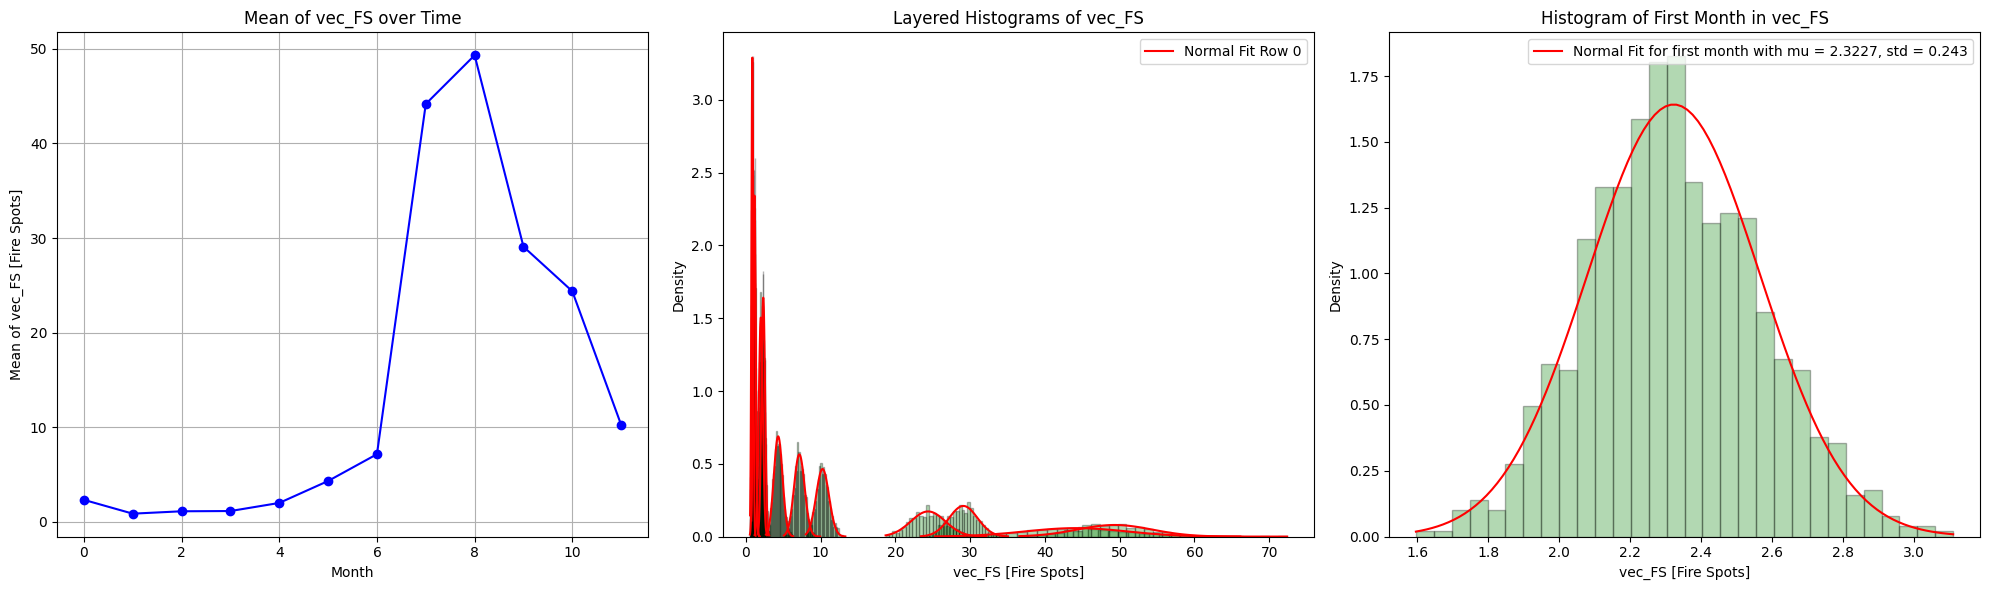

In [22]:
months = 12
variable = 'vec_FS'

# Compute the mean for the first 'months'
mean_ = np.nanmean(bootstrap_means[variable], axis=1)[:months]

# Create the figure with subplots
fig, ax = plt.subplots(1, 3, figsize=(20, 6))  # Correctly setting up 3 subplots

# Subplot 1: Line plot of mean_ over time
ax[0].plot(mean_, marker='o', color='b')
ax[0].set_xlabel('Month')
ax[0].set_ylabel(f'Mean of {variable} [{column_units[variable]}]')
ax[0].set_title(f'Mean of {variable} over Time')
ax[0].grid(True)

# Subplot 2: Layered histograms of each row in bootstrap_means[variable]
for i in range(min(months, len(bootstrap_means[variable]))):  # Ensure valid indices
    # Histogram
    data = bootstrap_means[variable][i]
    ax[1].hist(data, bins=30, alpha=0.3, color='g', edgecolor='black', density=True)

    # Fit and plot a normal distribution for comparison
    mu, std = np.mean(data), np.std(data)
    x = np.linspace(min(data), max(data), 100)
    pdf = stats.norm.pdf(x, mu, std)
    ax[1].plot(x, pdf, color='red', label=f'Normal Fit Row {i}' if i == 0 else "")

# Adjust labels and titles for the histogram subplot
ax[1].set_xlabel(f'{variable} [{column_units[variable]}]')
ax[1].set_ylabel('Density')
ax[1].set_title(f'Layered Histograms of {variable}')
ax[1].legend()

# Subplot 3: Histogram for the first row of bootstrap_means[variable]
# Histogram
data = bootstrap_means[variable][0]  # Use the first row for this subplot
ax[2].hist(data, bins=30, alpha=0.3, color='g', edgecolor='black', density=True)

# Fit and plot a normal distribution for comparison
mu, std = np.mean(data), np.std(data)
x = np.linspace(min(data), max(data), 100)
pdf = stats.norm.pdf(x, mu, std)
ax[2].plot(x, pdf, color='red', label=f'Normal Fit for first month with mu = {round(mu, 4)}, std = {round(std, 4)}')

# Adjust labels and titles for the histogram subplot
ax[2].set_xlabel(f'{variable} [{column_units[variable]}]')
ax[2].set_ylabel('Density')
ax[2].set_title(f'Histogram of First Month in {variable}')
ax[2].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [24]:
def calc_avg(data, column):
    all_monthly_data = []
    for month in range(1, 13):
        monthly_data = np.zeros_like(df_sorted[df_sorted['vec_Month'] == 1][column].values)
        for i in range(month, 121, 12):
            a = df_sorted[df_sorted['vec_Month'] == i][column].values
            monthly_data+= a
        all_monthly_data.append(monthly_data/10)

    all_monthly_data = np.array(all_monthly_data)

    return all_monthly_data

all_monthly_data = calc_avg(df_sorted,"vec_FS")
mean_monthly_data = np.nanmean(all_monthly_data, axis=1)

all_monthly_data.shape


(12, 558)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


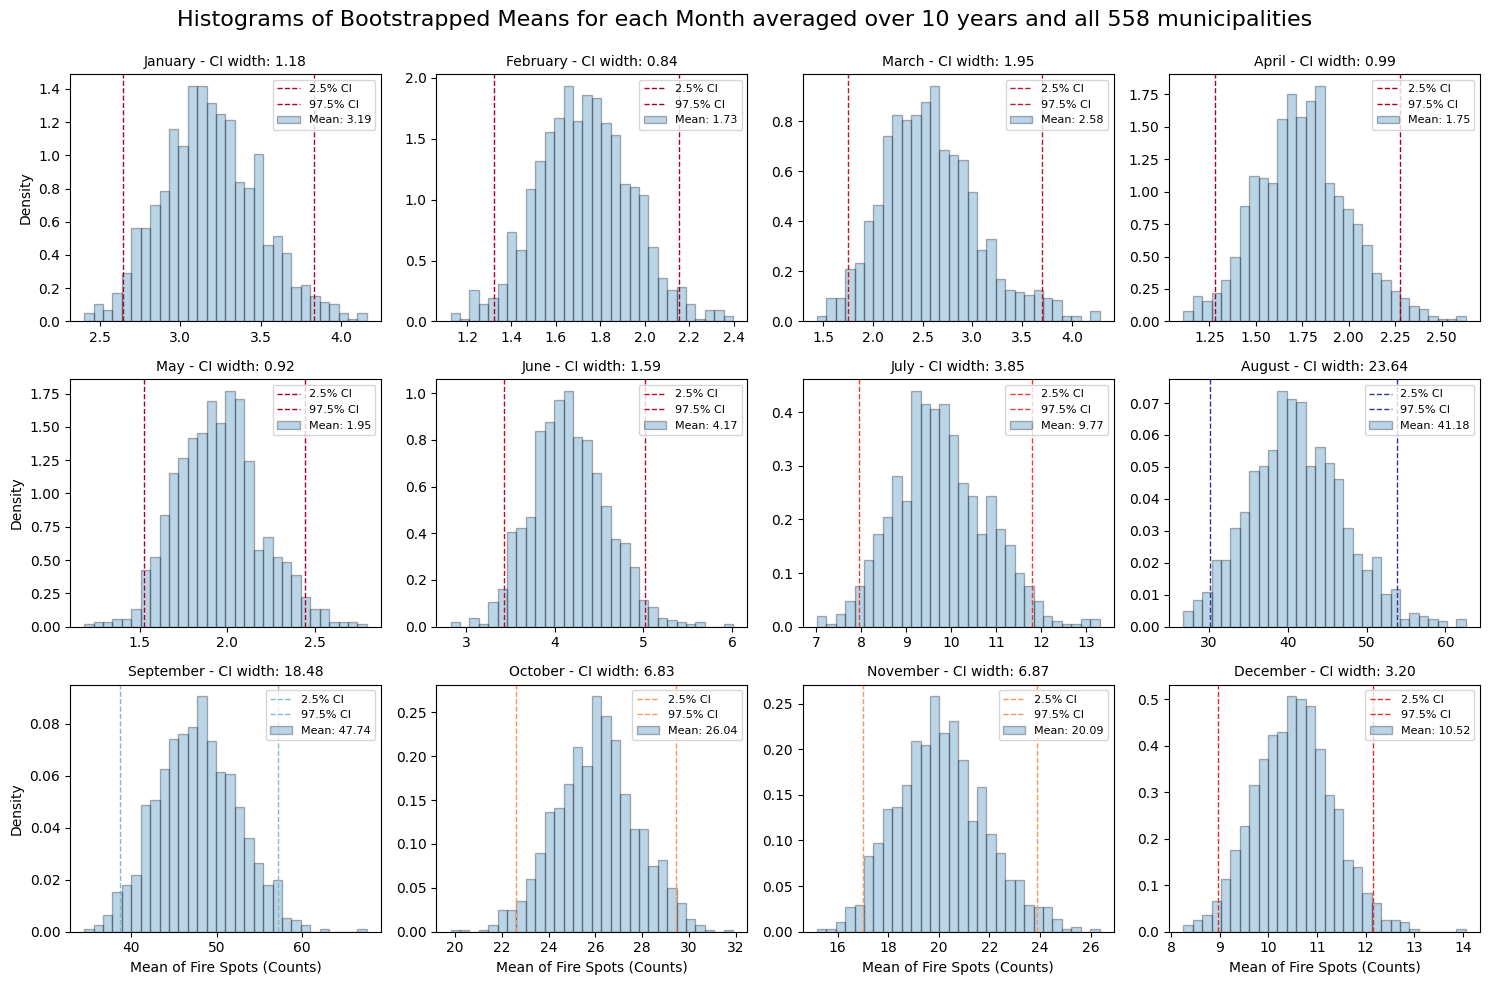

In [28]:
months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]

fig, axes = plt.subplots(3, 4, figsize=(15, 10))  # Create a 3x4 grid of subplots
all_bootstrap_means = []

# Prepare to find global min/max for x and y axes
global_x_min, global_x_max = float('inf'), float('-inf')
global_y_min, global_y_max = float('inf'), float('-inf')

# First pass: calculate histograms, confidence intervals, and find global ranges
histograms = []
conf_intervals = []  # Store confidence intervals for each month
ci_widths = []  # To store confidence interval widths
for i in range(12):
    bootstrap_means_month = bootstrap(all_monthly_data[i], n_bootstrap, n_samples, np.mean)
    mean_month = np.nanmean(bootstrap_means_month)
    
    # Calculate histogram and density
    hist, bin_edges = np.histogram(bootstrap_means_month, bins=30, density=True)
    histograms.append((hist, bin_edges, mean_month))
    
    # Calculate 95% confidence interval
    lower_ci = np.percentile(bootstrap_means_month, 2.5)
    upper_ci = np.percentile(bootstrap_means_month, 97.5)
    conf_intervals.append((lower_ci, upper_ci))
    
    # Calculate the width of the confidence interval
    ci_width = upper_ci - lower_ci
    ci_widths.append(ci_width)

# Normalize the confidence interval widths for color mapping
min_ci_width = min(ci_widths)
max_ci_width = max(ci_widths)
norm = plt.Normalize(min_ci_width, max_ci_width)

# Color map for confidence interval widths
cmap = plt.cm.RdYlBu  # You can use other color maps as well (e.g., 'Reds', 'coolwarm', etc.)

# Second pass: plot histograms with unified axes and confidence intervals
for i in range(12):
    ax = axes[i // 4, i % 4]  # Get the correct subplot
    hist, bin_edges, mean_month = histograms[i]
    lower_ci, upper_ci = conf_intervals[i]
    
    # Plot histogram
    ax.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), alpha=0.3, edgecolor='black', align='edge',
           label=f'Mean: {mean_month:.2f}')
    
    # Calculate the color based on the confidence interval width
    ci_width = ci_widths[i]
    color = cmap(norm(ci_width))  # Get the color from the color map

    # Add confidence interval as a vertical line
    ax.axvline(lower_ci, color=color, linestyle='--', label='2.5% CI', linewidth=1)
    ax.axvline(upper_ci, color=color, linestyle='--', label='97.5% CI', linewidth=1)
    
    # Annotate with mean and CI
    ax.text(mean_month, global_y_max * 0.9, f"{mean_month:.2f}\n[{lower_ci:.2f}, {upper_ci:.2f}]",
            ha="center", fontsize=8, color="blue", bbox=dict(facecolor='white', alpha=0.5))
    
    # Add the confidence interval width to the title with the CI width in color
    ax.set_title(f"{months[i]} - CI width: {ci_width:.2f}", fontsize=10)
    ax.legend(fontsize=8)

    # Set x-axis label only for the bottom row
    if i // 4 == 2:
        ax.set_xlabel('Mean of Fire Spots (Counts)')

    # Set y-axis label only for the left column
    if i % 4 == 0:
        ax.set_ylabel('Density')

# Adjust the layout and overall title
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Histograms of Bootstrapped Means for each Month averaged over 10 years and all 558 municipalities', fontsize=16)
plt.show()

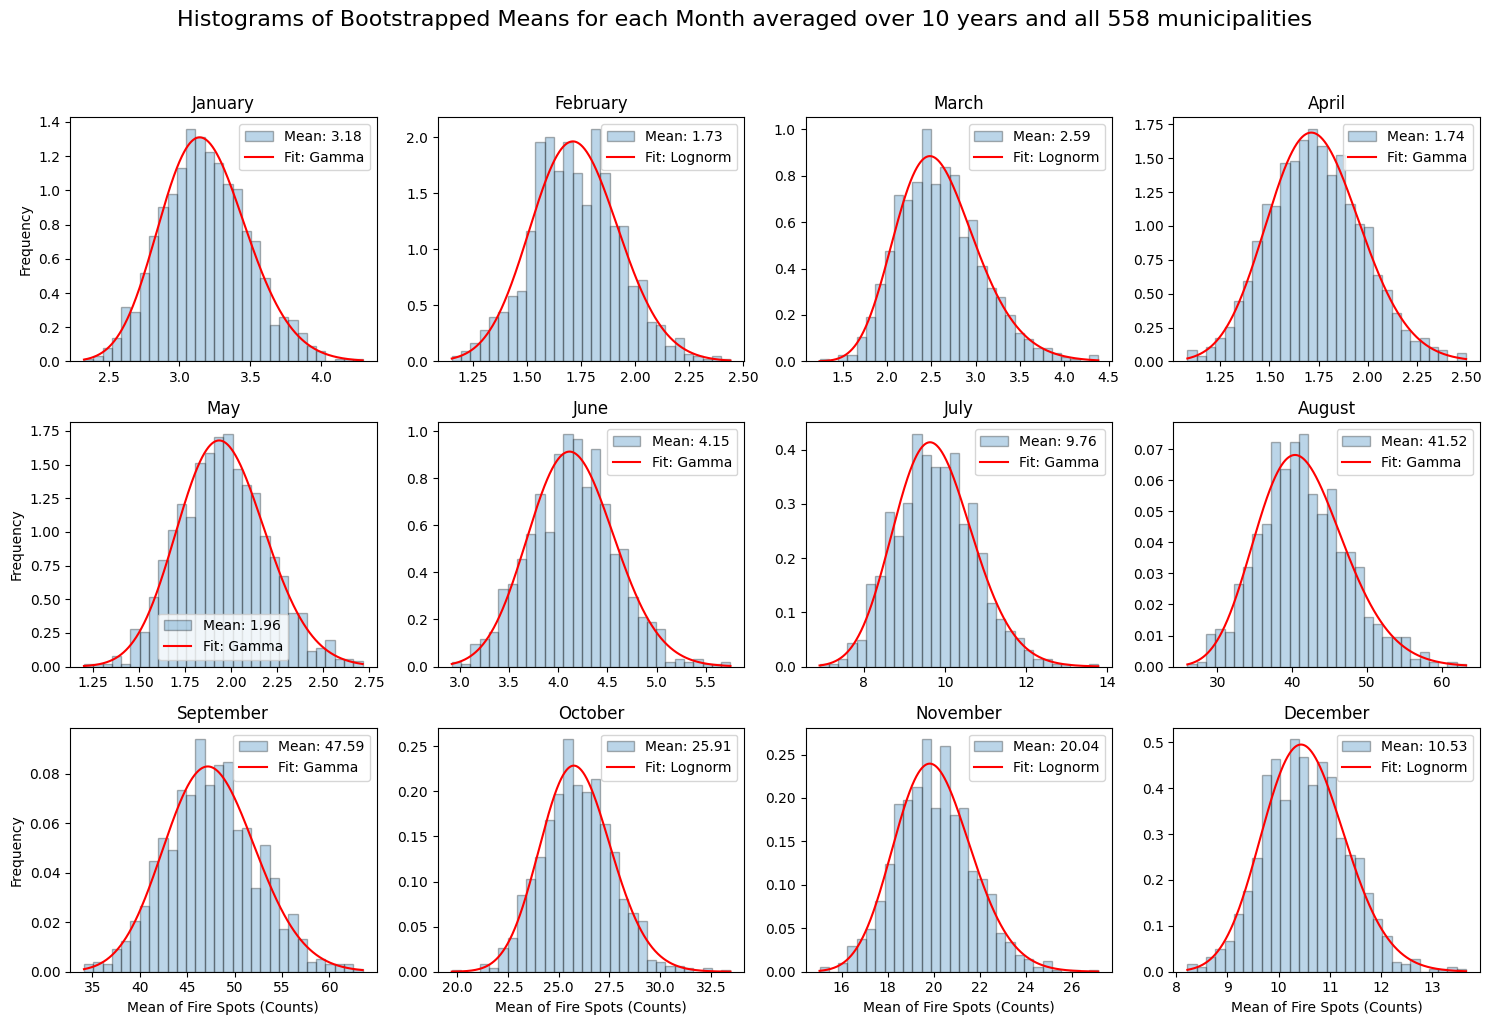

In [29]:
import scipy.stats as stats

# Assuming you already have bootstrap data and other variables defined

def fit_distribution(data):
    # Candidate distributions to fit
    dist_names = ['norm', 'gamma', 'lognorm', 'poisson']
    best_dist = None
    best_aic = np.inf
    best_params = None
    
    # Loop over all candidate distributions
    for dist_name in dist_names:
        dist = getattr(stats, dist_name)
        try:
            # Fit the distribution
            if dist_name == 'poisson':
                # For Poisson, we only need one parameter (lambda)
                params = (np.mean(data),)
            else:
                params = dist.fit(data)
            
            # Calculate log-likelihood
            log_likelihood = np.sum(np.log(dist.pdf(data, *params)))
            n_params = len(params)
            aic = 2 * n_params - 2 * log_likelihood
            
            # Update best distribution based on AIC
            if aic < best_aic:
                best_aic = aic
                best_dist = dist_name
                best_params = params
        except:
            continue
    
    return best_dist, best_params

months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
all_bootstrap_means = []

for i in range(12):
    ax = axes[i // 4, i % 4]
    bootstrap_means_month = bootstrap(all_monthly_data[i], n_bootstrap, n_samples, np.mean)
    mean_month = np.nanmean(bootstrap_means_month)
    ax.hist(bootstrap_means_month, bins=30, alpha=0.3, edgecolor='black', density=True, label=f'Mean: {mean_month:.2f}')
    
    # Fit a distribution and add it to the plot
    best_dist, best_params = fit_distribution(bootstrap_means_month)
    
    # Generate x values for plotting the best fit
    x_values = np.linspace(min(bootstrap_means_month), max(bootstrap_means_month), 1000)
    
    if best_dist == 'norm':
        fitted_pdf = stats.norm.pdf(x_values, *best_params)
    elif best_dist == 'gamma':
        fitted_pdf = stats.gamma.pdf(x_values, *best_params)
    elif best_dist == 'lognorm':
        fitted_pdf = stats.lognorm.pdf(x_values, *best_params)
    elif best_dist == 'poisson':
        # For Poisson, we use the lambda parameter and generate the pmf (probability mass function)
        lambda_poisson = best_params[0]
        fitted_pdf = stats.poisson.pmf(np.floor(x_values), lambda_poisson)  # Use floor to match discrete values
    
    ax.plot(x_values, fitted_pdf, label=f'Fit: {best_dist.capitalize()}', color='red')
    ax.legend()
    
    # Set titles and labels
    ax.set_title(months[i])
    if i // 4 == 2:
        ax.set_xlabel('Mean of Fire Spots (Counts)')
    if i % 4 == 0:
        ax.set_ylabel('Frequency')
    
    all_bootstrap_means.append(bootstrap_means_month)

# Layout adjustments
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Histograms of Bootstrapped Means for each Month averaged over 10 years and all 558 municipalities', fontsize=16, y=1.02)
plt.show()

# Collect all bootstrap means into a numpy array
all_bootstrap_means = np.array(all_bootstrap_means)

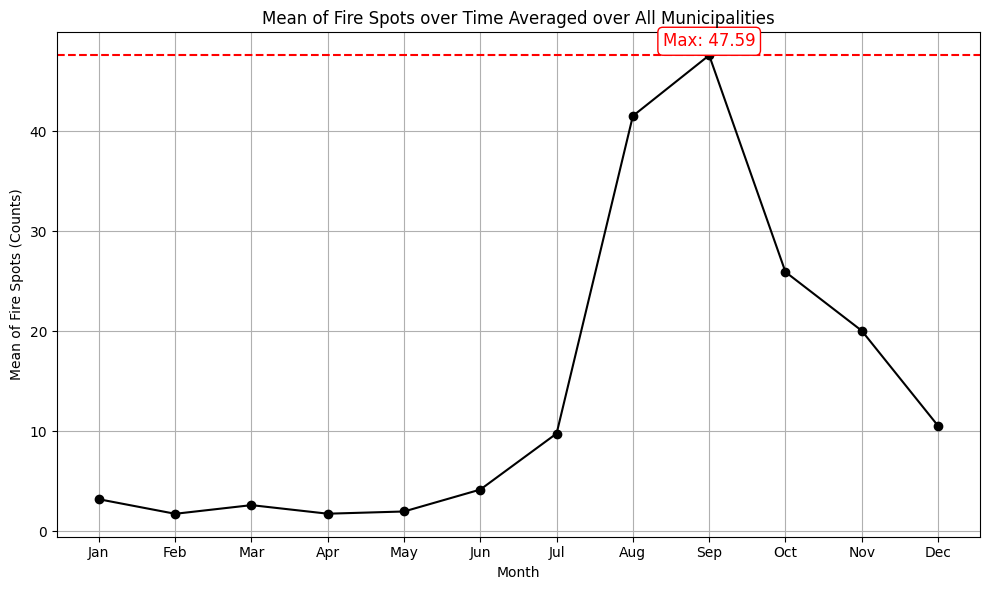

In [30]:

# Example data (replace with your actual 'all_bootstrap_means' data)
# all_bootstrap_means = ...

# Plot the data
plt.figure(figsize=(10, 6))
mean_values = np.nanmean(all_bootstrap_means, axis=1)
plt.plot(mean_values, marker='o', color='black')

# Set x-axis labels for months (1-12 for simplicity)
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(ticks=range(12), labels=months)

# Set the x and y axis labels
plt.xlabel('Month')
plt.ylabel('Mean of Fire Spots (Counts)')

# Add the title
plt.title('Mean of Fire Spots over Time Averaged over All Municipalities')

# Add grid
plt.grid(True)

# Find the maximum value and its corresponding month
max_value = np.nanmax(mean_values)
max_month_index = np.argmax(mean_values)

# Plot a horizontal line at the maximum value
plt.axhline(y=max_value, color='r', linestyle='--')

# Add a text box to explain the line
plt.text(
    max_month_index, max_value + 0.5,  # Positioning the text slightly above the line
    f'Max: {max_value:.2f}',  # Value of the maximum
    color='red', fontsize=12, ha='center', va='bottom',
    bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3')
)

# Show the plot
plt.tight_layout()
plt.show()

In [31]:
all_bootstrap_means

array([[ 3.0797491 ,  3.27275986,  3.50448029, ...,  2.85949821,
         2.78942652,  2.48870968],
       [ 1.70394265,  1.6202509 ,  1.54910394, ...,  1.53369176,
         1.97043011,  1.81577061],
       [ 2.11792115,  2.97491039,  2.48996416, ...,  1.68315412,
         2.04426523,  2.95089606],
       ...,
       [28.08476703, 24.05519713, 23.46541219, ..., 24.81827957,
        24.33512545, 24.95860215],
       [21.36075269, 17.61236559, 20.07060932, ..., 20.44623656,
        20.20053763, 18.42956989],
       [ 9.89157706, 13.45537634, 10.1953405 , ..., 10.15250896,
        10.61505376, 10.4655914 ]])

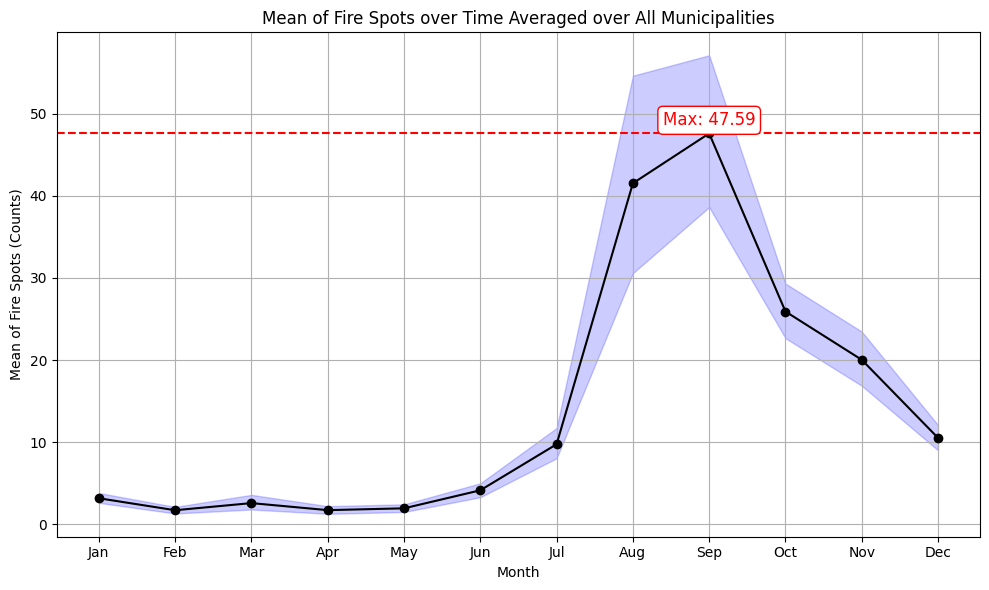

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Example data (replace these with your actual 'all_bootstrap_means' data)
# all_bootstrap_means = ...

# Compute the mean values and the confidence intervals (replace with actual data)
mean_values = np.nanmean(all_bootstrap_means, axis=1)

# Calculate the 95% confidence intervals
# Assuming you have precomputed these, replace with your actual lower and upper CI values
lower_ci = np.nanpercentile(all_bootstrap_means, 2.5, axis=1)  # 2.5th percentile
upper_ci = np.nanpercentile(all_bootstrap_means, 97.5, axis=1)  # 97.5th percentile

# Plot the data with confidence intervals
plt.figure(figsize=(10, 6))

plt.plot(mean_values, color='black', label='Mean')
# Fill the area between the lower and upper confidence intervals
plt.fill_between(range(12), lower_ci, upper_ci, color='blue', alpha=0.2, label='95% CI')

# Plot the means as points
plt.plot(range(12), mean_values, 'o', color='black', label='Mean')

# Set x-axis labels for months (1-12 for simplicity)
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(ticks=range(12), labels=months)

# Set the x and y axis labels
plt.xlabel('Month')
plt.ylabel('Mean of Fire Spots (Counts)')

# Add the title
plt.title('Mean of Fire Spots over Time Averaged over All Municipalities')

# Add grid
plt.grid(True)

# Find the maximum value and its corresponding month
max_value = np.nanmax(mean_values)
max_month_index = np.argmax(mean_values)

# Plot a horizontal line at the maximum value
plt.axhline(y=max_value, color='r', linestyle='--')

# Add a text box to explain the line
plt.text(
    max_month_index, max_value + 0.5,  # Positioning the text slightly above the line
    f'Max: {max_value:.2f}',  # Value of the maximum
    color='red', fontsize=12, ha='center', va='bottom',
    bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3')
)

# Show the plot
plt.tight_layout()
plt.show()

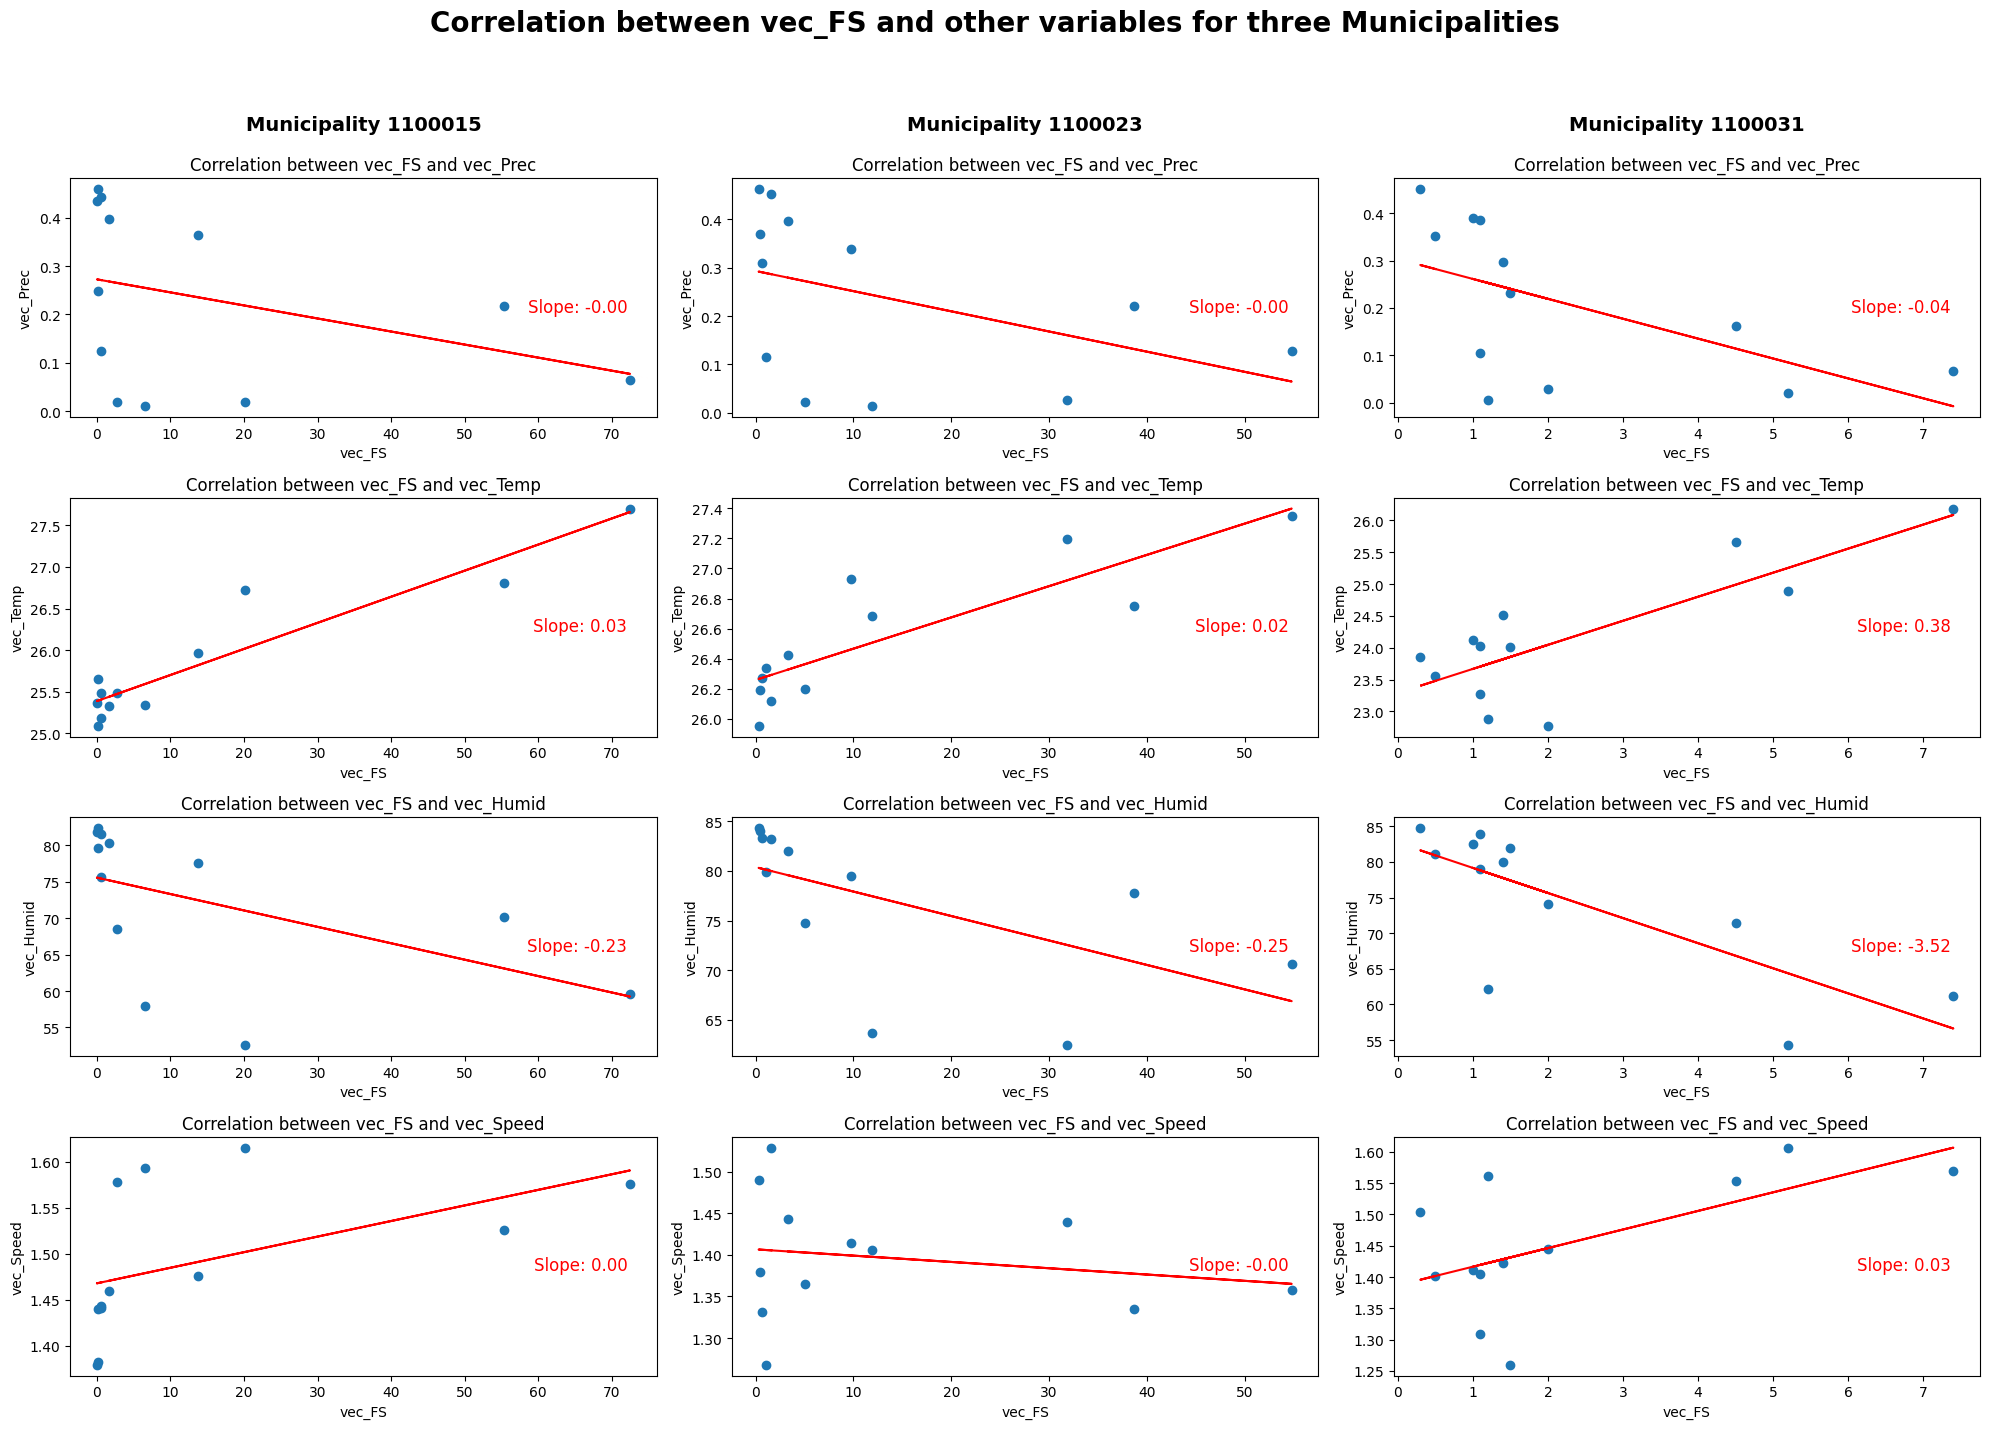

In [33]:
from scipy.stats import linregress

random_munic_indices = [0, 1, 2]

variables = ['vec_Prec', 'vec_Temp', 'vec_Humid', 'vec_Speed']

fig, axs = plt.subplots(len(variables), 3, figsize=(20, 15))

for col, nmb_munic in enumerate(random_munic_indices):
    all_monthly_data_fs = calc_avg(df_sorted, "vec_FS")[:, nmb_munic]

    # Scatter plot for each variable against all_monthly_data_fs
    for row, var in enumerate(variables):
        data = calc_avg(df_sorted, var)[:, nmb_munic]
        axs[row, col].scatter(all_monthly_data_fs, data)
        
        # Fit a line to the data
        slope, intercept, r_value, p_value, std_err = linregress(all_monthly_data_fs, data)
        line = slope * all_monthly_data_fs + intercept
        axs[row, col].plot(all_monthly_data_fs, line, color='red')
        
        # Add slope label
        axs[row, col].annotate(f'Slope: {slope:.2f}', xy=(0.95, 0.5), xycoords='axes fraction', ha='right', va='top', fontsize=12, color='red')
        
        axs[row, col].set_title(f'Correlation between vec_FS and {var}')
        axs[row, col].set_xlabel('vec_FS')
        axs[row, col].set_ylabel(var)

    # Add the municipality number at the top of each column
    axs[0, col].annotate(f'Municipality {df_sorted["vec_Munic"].unique()[nmb_munic]}', xy=(0.5, 1.2), xycoords='axes fraction', ha='center', fontsize=14, weight='bold')

fig.suptitle('Correlation between vec_FS and other variables for three Municipalities', fontsize=20, weight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the title
plt.show()

In [34]:
n_bootstrap = 30000
n_samples = 10
munic_number = 0

def return_all_data_per_munic(data, column):
    all_monthly_data = []
    for month in range(1, 13):
        monthly_data = []
        for i in range(month, 121, 12):
            a = df_sorted[df_sorted['vec_Month'] == i][column].values
            monthly_data.append(a)
        all_monthly_data.append(monthly_data)

    all_monthly_data = np.array(all_monthly_data)

    return all_monthly_data

data = return_all_data_per_munic(df_sorted, "vec_FS")
data_munic_ = data[:,:,munic_number]

all_bootstrap_means = []
for i, month_data in enumerate(data_munic_):
    bootstrap_means_month = bootstrap(month_data, n_bootstrap, n_samples, np.mean)
    all_bootstrap_means.append(bootstrap_means_month)

all_bootstrap_means = np.array(all_bootstrap_means)

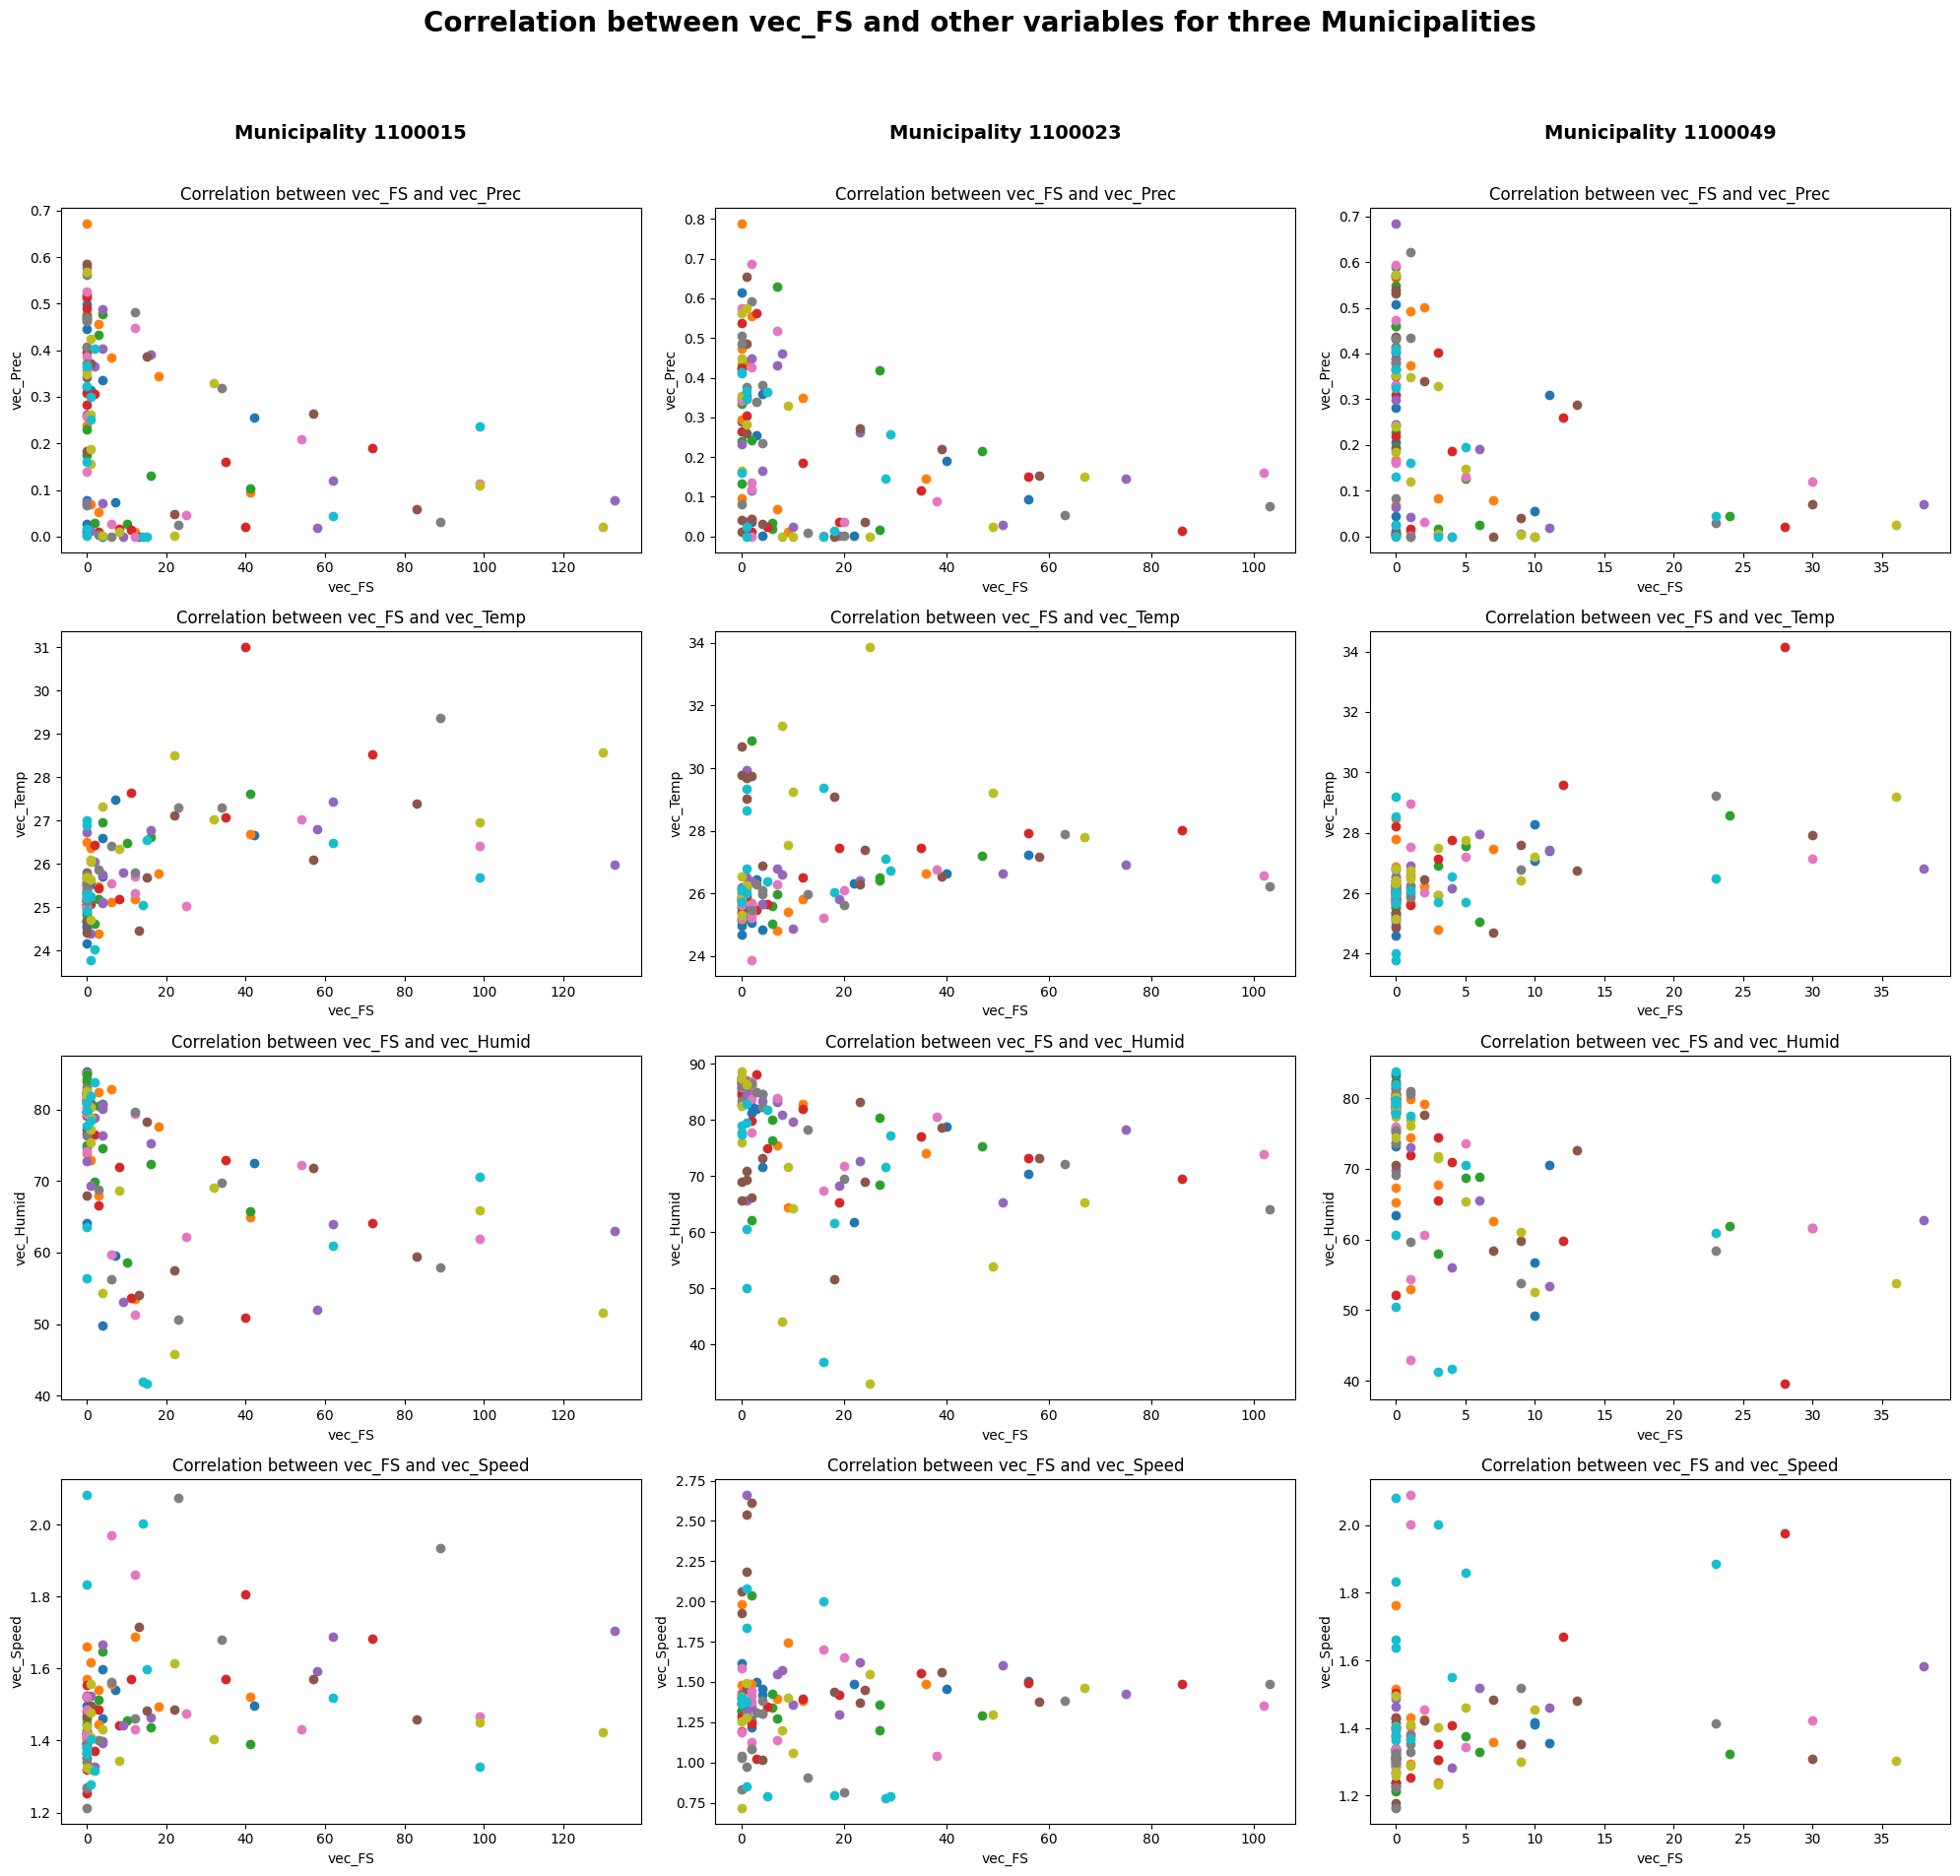

In [35]:
random_munic_indices = [0, 1, 3]
variables = ['vec_Prec', 'vec_Temp', 'vec_Humid', 'vec_Speed']
fig, axs = plt.subplots(len(variables), 3, figsize=(20, 20))
for col, nmb_munic in enumerate(random_munic_indices):
    all_monthly_data_fs = return_all_data_per_munic(data, "vec_FS")[:,:, nmb_munic]
    for i in range(0,10):
        fs = all_monthly_data_fs[:,i]
        for row, var in enumerate(variables):
            data = return_all_data_per_munic(data, var)[:,:, nmb_munic][:,i]
            axs[row, col].scatter(fs, data)
            #slope, intercept, r_value, p_value, std_err = linregress(fs, data)
            #line = slope * fs + intercept
            #axs[row, col].plot(fs, line, color='red')
            #axs[row, col].annotate(f'Slope: {slope:.2f}', xy=(0.95, 0.5), xycoords='axes fraction', ha='right', va='top', fontsize=12, color='red')
            axs[row, col].set_title(f'Correlation between vec_FS and {var}')
            axs[row, col].set_xlabel('vec_FS')
            axs[row, col].set_ylabel(var)
            
    axs[0, col].annotate(f'Municipality {df_sorted["vec_Munic"].unique()[nmb_munic]}', xy=(0.5, 1.2), xycoords='axes fraction', ha='center', fontsize=14, weight='bold')

fig.suptitle('Correlation between vec_FS and other variables for three Municipalities', fontsize=20, weight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the title
plt.show()


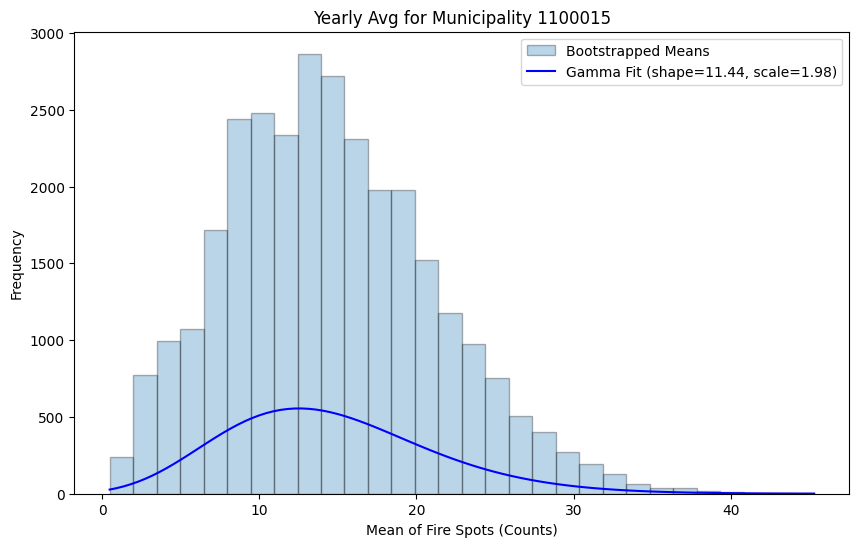

In [37]:
from scipy.stats import poisson, norm, gamma, expon, lognorm

# Generate bootstrap means
n_bootstrap = 30000
n_samples = 12
munic = 0 # Municipality index
data = return_all_data_per_munic(df_sorted, "vec_FS")[:, :, munic]
data_munic_ = np.mean(data, axis=1)
bootstrap_means_month = bootstrap(data_munic_, n_bootstrap, n_samples, np.mean)

# Define the distributions to compare
distributions = [poisson, norm, gamma, expon, lognorm]
best_aic = np.inf
best_bic = np.inf
best_dist = None
best_params = None

# Fit and compare distributions
for dist in distributions:
    try:
        # Fit distribution
        params = dist.fit(bootstrap_means_month) if dist != poisson else (np.mean(bootstrap_means_month),)  # Poisson doesn't need fit()
        
        # Log-Likelihood
        log_likelihood = np.sum(np.log(dist.pdf(bootstrap_means_month, *params)))
        
        # Number of parameters (degree of freedom for the distribution)
        num_params = len(params)
        
        # AIC and BIC calculation
        aic = 2 * num_params - 2 * log_likelihood
        bic = np.log(len(bootstrap_means_month)) * num_params - 2 * log_likelihood
        
        # Select the best fitting distribution based on AIC/BIC
        if aic < best_aic and bic < best_bic:
            best_aic = aic
            best_bic = bic
            best_dist = dist
            best_params = params
    except Exception as e:
        continue

# Plot the best fitting distribution
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_means_month, bins=30, alpha=0.3, edgecolor='black', density=False, label='Bootstrapped Means')

# Plot the best fitting distribution
x_vals = np.linspace(np.min(bootstrap_means_month), np.max(bootstrap_means_month), 100)

if best_dist == poisson:
    lambda_hat = best_params[0]
    poisson_pmf = poisson.pmf(x_vals, lambda_hat) * len(bootstrap_means_month) * (30 / len(x_vals))
    plt.plot(x_vals, poisson_pmf, 'r-', label=f'Poisson Fit ($\lambda$={lambda_hat:.2f})')
elif best_dist == norm:
    mu, sigma = best_params
    gaussian_pdf = norm.pdf(x_vals, mu, sigma) * len(bootstrap_means_month) * (30 / len(x_vals))
    plt.plot(x_vals, gaussian_pdf, 'g-', label=f'Gaussian Fit ($\mu$={mu:.2f}, $\sigma$={sigma:.2f})')
elif best_dist == gamma:
    shape, loc, scale = best_params
    gamma_pdf = gamma.pdf(x_vals, shape, loc, scale) * len(bootstrap_means_month) * (30 / len(x_vals))
    plt.plot(x_vals, gamma_pdf, 'b-', label=f'Gamma Fit (shape={shape:.2f}, scale={scale:.2f})')
elif best_dist == expon:
    loc, scale = best_params
    expon_pdf = expon.pdf(x_vals, loc, scale) * len(bootstrap_means_month) * (30 / len(x_vals))
    plt.plot(x_vals, expon_pdf, 'm-', label=f'Exponential Fit (scale={scale:.2f})')
elif best_dist == lognorm:
    shape, loc, scale = best_params
    lognorm_pdf = lognorm.pdf(x_vals, shape, loc, scale) * len(bootstrap_means_month) * (30 / len(x_vals))
    plt.plot(x_vals, lognorm_pdf, 'c-', label=f'Log-Normal Fit (shape={shape:.2f}, scale={scale:.2f})')

# Add labels and title
plt.xlabel('Mean of Fire Spots (Counts)')
plt.ylabel('Frequency')
plt.title(f'Yearly Avg for Municipality {df_sorted["vec_Munic"].unique()[munic]}')
plt.legend()
plt.show()

In [38]:
"""n_bootstrap = 30000
n_samples = 12
munic = 0  # Index der Gemeinde
data = return_all_data_per_munic(df_sorted, "vec_FS")[:, :, munic]
data_munic_ = np.mean(data, axis=1)
bootstrap_means_month = bootstrap(data_munic_, n_bootstrap, n_samples, np.mean)

# Fit der Normalverteilung auf die Bootstrap-Mittelwerte
mu, sigma = norm.fit(bootstrap_means_month)

# Berechne Werte für die normalverteilte Dichtefunktion
x_vals = np.linspace(np.min(bootstrap_means_month), np.max(bootstrap_means_month), 100)

# Berechne die Normalverteilung (Dichte)
normal_pdf = norm.pdf(x_vals, mu, sigma)

# Plot der Histogramme mit Dichte
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_means_month, bins=30, alpha=0.3, edgecolor='black', density=True, label='Bootstrapped Means')

# Skaliere die Normalverteilung auf die gleiche Dichte wie das Histogramm
plt.plot(x_vals, normal_pdf, 'r-', label=f'Normal Fit ($\mu$={mu:.2f}, $\sigma$={sigma:.2f})')

# Berechne die Werte für die Poisson-Verteilung (Poisson PMF)
x_vals = np.arange(0, np.ceil(max(bootstrap_means_month)) + 1)  # Wertebereich für Poisson PMF
poisson_pmf = poisson.pmf(x_vals, lambda_hat)


# Plot der Poisson-Verteilung
plt.plot(x_vals, poisson_pmf, 'g-', label=f'Poisson Fit ($\lambda$={lambda_hat:.2f})')

# Hinzufügen von Achsenbeschriftungen und Titel
plt.xlabel('Mean of Fire Spots (Counts)')
plt.ylabel('Density')
plt.title(f'Yearly Avg for Municipality {df_sorted["vec_Munic"].unique()[munic]}')
plt.legend()
plt.show()"""

'n_bootstrap = 30000\nn_samples = 12\nmunic = 0  # Index der Gemeinde\ndata = return_all_data_per_munic(df_sorted, "vec_FS")[:, :, munic]\ndata_munic_ = np.mean(data, axis=1)\nbootstrap_means_month = bootstrap(data_munic_, n_bootstrap, n_samples, np.mean)\n\n# Fit der Normalverteilung auf die Bootstrap-Mittelwerte\nmu, sigma = norm.fit(bootstrap_means_month)\n\n# Berechne Werte für die normalverteilte Dichtefunktion\nx_vals = np.linspace(np.min(bootstrap_means_month), np.max(bootstrap_means_month), 100)\n\n# Berechne die Normalverteilung (Dichte)\nnormal_pdf = norm.pdf(x_vals, mu, sigma)\n\n# Plot der Histogramme mit Dichte\nplt.figure(figsize=(10, 6))\nplt.hist(bootstrap_means_month, bins=30, alpha=0.3, edgecolor=\'black\', density=True, label=\'Bootstrapped Means\')\n\n# Skaliere die Normalverteilung auf die gleiche Dichte wie das Histogramm\nplt.plot(x_vals, normal_pdf, \'r-\', label=f\'Normal Fit ($\\mu$={mu:.2f}, $\\sigma$={sigma:.2f})\')\n\n# Berechne die Werte für die Poisson-Ve

In [39]:
# Annahme: df_sorted existiert bereits
df_sorted_copy = df_sorted.copy()
df_sorted_copy = df_sorted_copy.sort_values(by=['vec_Munic', 'vec_Month']).reset_index(drop=True)

# Einzigartige Gemeinden
unique_mun = np.array(df_sorted_copy['vec_Munic'].unique())

# Liste für die Ergebnisse
all_municipality_monthly_check = []
all_municipality_monthly_averages = []

for i, mun in enumerate(unique_mun):
    # Filter für die Gemeinde
    df_sorted_copy_month = df_sorted_copy[df_sorted_copy['vec_Munic'] == mun].copy()
    

    # Create an array with values from 1 to 12 repeated 10 times
    month_array = np.tile(np.arange(1, 13), 10)

    # Replace the 'vec_Month' column with this new array
    df_sorted_copy_month["vec_Month"] = month_array

    all_municipality_monthly_check.append(df_sorted_copy_month)

    grouped = df_sorted_copy_month.groupby('vec_Month').mean()

    
    # Gemeinde-ID hinzufügen, damit sie nicht verloren geht
    grouped['vec_Munic'] = mun

    # Ergebnis zur Liste hinzufügen
    all_municipality_monthly_averages.append(grouped)

# Alle Gruppierungen zusammenführen
result = pd.concat(all_municipality_monthly_averages).reset_index()
print(result)

      vec_Month  vec_Munic  vec_Area  vec_FS  vec_LUT  vec_Prec   vec_Temp  \
0             1    1100015  7067.025     0.6   5.5411  0.442681  25.180531   
1             2    1100015  7067.025     0.2   5.5411  0.458807  25.091436   
2             3    1100015  7067.025     0.0   5.5411  0.434869  25.361464   
3             4    1100015  7067.025     0.1   5.5411  0.249202  25.651188   
4             5    1100015  7067.025     0.5   5.5411  0.124312  25.483501   
...         ...        ...       ...     ...      ...       ...        ...   
6691          8    5108956  5150.562    39.5   2.1029  0.021064  27.515831   
6692          9    5108956  5150.562    55.3   2.1029  0.089157  28.402732   
6693         10    5108956  5150.562    15.2   2.1029  0.178092  27.454476   
6694         11    5108956  5150.562     2.7   2.1029  0.301232  26.552005   
6695         12    5108956  5150.562     0.8   2.1029  0.298399  26.245959   

      vec_Humid  vec_Speed  
0     81.531848   1.441496  
1    

/var/folders/dm/_7xx464s467cm2g79s2z8cvw0000gq/T/ipykernel_11606/3642833972.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Layout anpassen


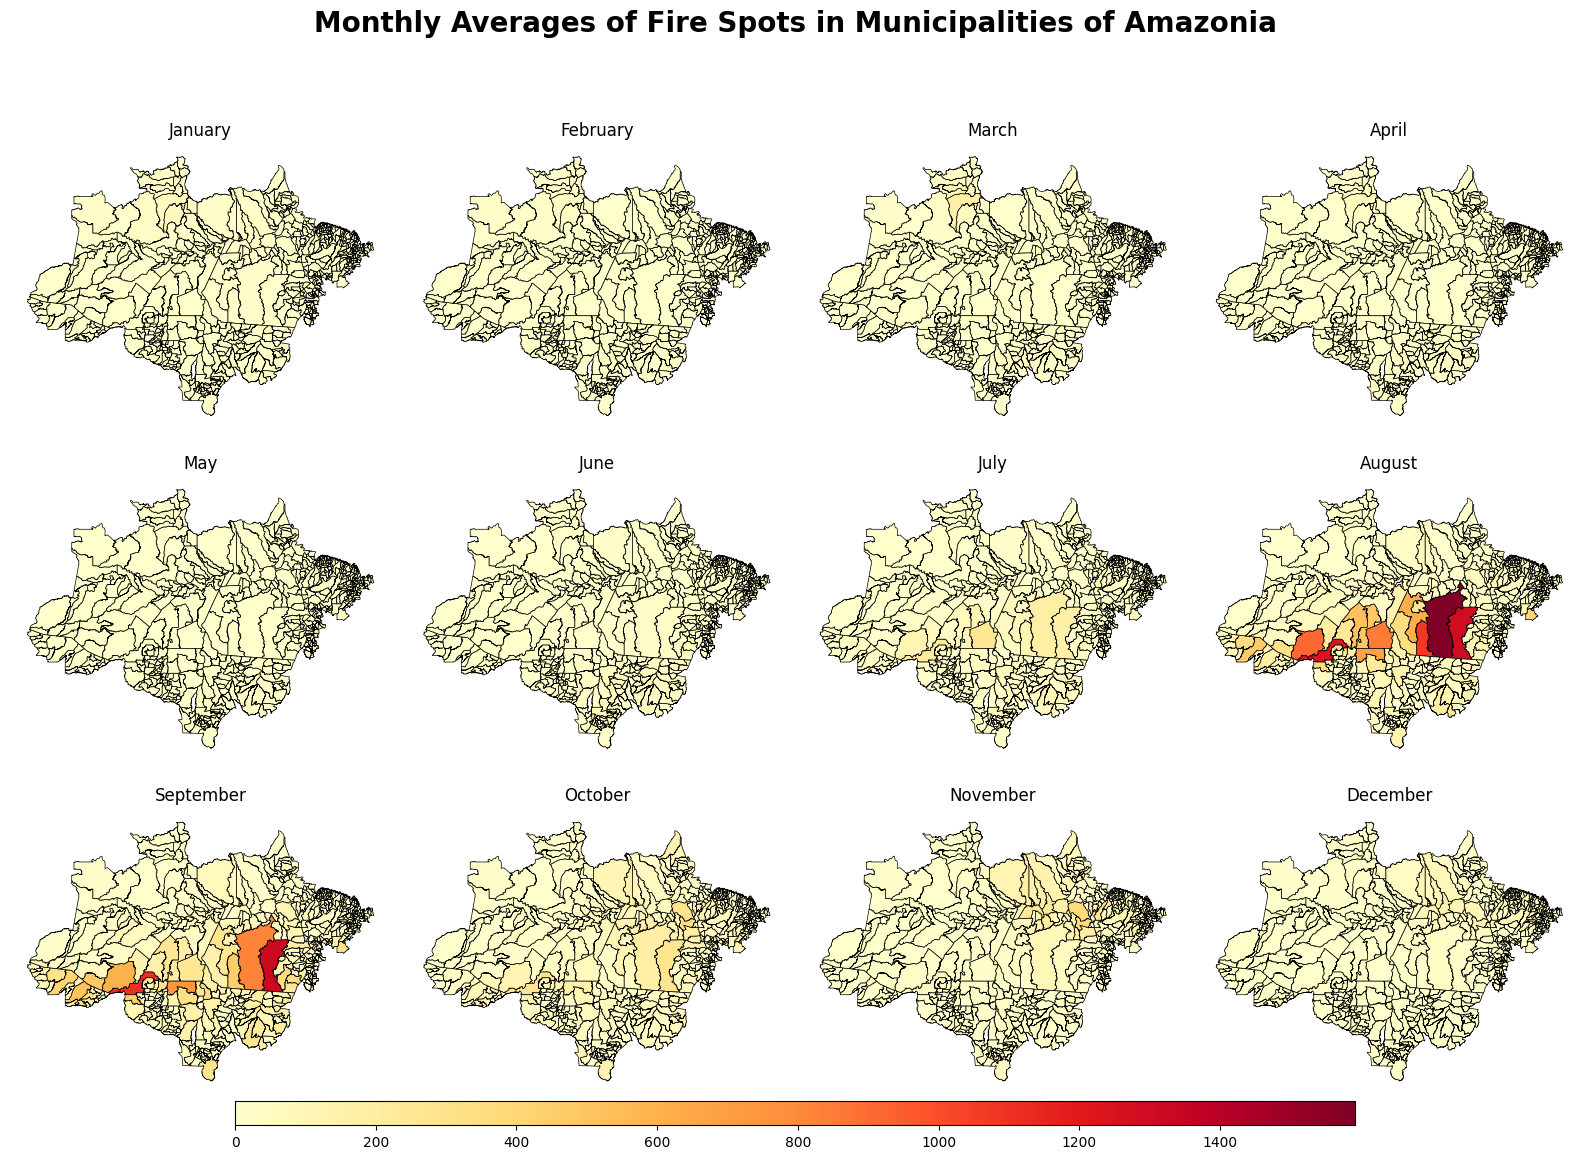

In [40]:
from matplotlib import gridspec
import matplotlib.pyplot as plt
import geobr
import geopandas as gpd

# Geodaten laden
gdf = geobr.read_municipality(year=2020)
gdf_states = geobr.read_state(year=2020)

# Einzigartige Gemeinden aus dem Ergebnis-Datensatz
unique_municipals = result['vec_Munic'].unique()

# Filtere Geodaten basierend auf den Gemeinden
gdf_filtered = gdf[gdf['code_muni'].isin(unique_municipals)]

# Month names
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

# Berechnung des Farbbereichs basierend auf dem Gesamtbereich der vec_FS
vmin = result['vec_FS'].min()  # Global min for the entire dataset
vmax = result['vec_FS'].max()  # Global max for the entire dataset

# Plot erstellen
fig = plt.figure(figsize=(16, 12), facecolor='white')
gs = gridspec.GridSpec(3, 4)

for i in range(3):
    for k in range(4):
        # Subplot erstellen
        axis = fig.add_subplot(gs[i, k])

        # Aktueller Monat (1-basiert)
        current_month = i * 4 + k + 1

        # Filtere die Werte für den aktuellen Monat
        month_data = result[result['vec_Month'] == current_month]

        # Geodaten mit den Werten für den aktuellen Monat verknüpfen
        gdf_filtered_month = gdf_filtered.merge(
            month_data, left_on='code_muni', right_on='vec_Munic', how='left'
        )

        # Plotten mit der globalen Farbskala (vmin, vmax)
        gdf_filtered_month.plot(
            ax=axis,
            column='vec_FS',  # Werte für Farbgebung
            cmap='YlOrRd',
            legend=False,
            edgecolor='k',
            linewidth=0.5,
            vmin=vmin,  # Set global min
            vmax=vmax   # Set global max
        )

        # Achsenticks und Titel setzen
        axis.set_xticks([])
        axis.set_yticks([])
        axis.set_title(month_names[i * 4 + k])

        # Rahmen ausblenden
        for spine in axis.spines.values():
            spine.set_visible(False)

# Farblegende hinzufügen
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])  # Position der Farblegende
sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')

# Haupttitel hinzufügen
fig.suptitle('Monthly Averages of Fire Spots in Municipalities of Amazonia', 
             fontsize=20, fontweight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Layout anpassen
plt.show()

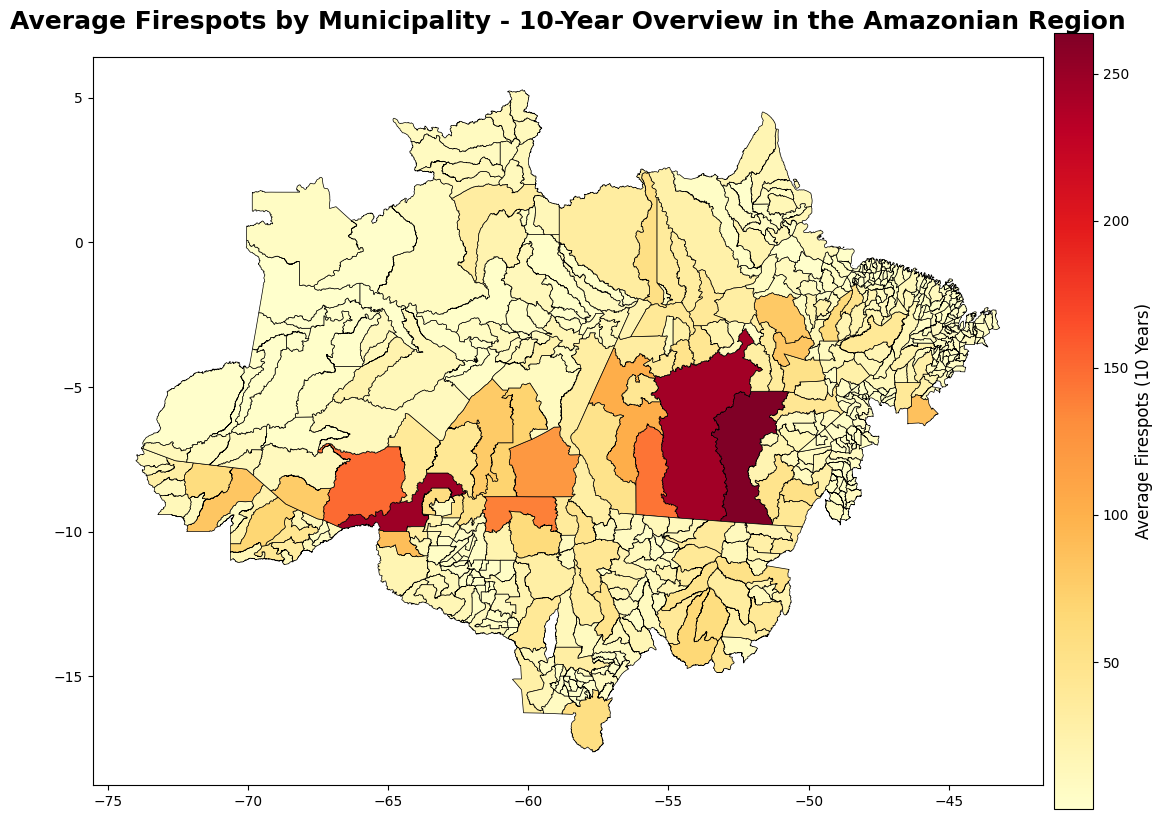

In [41]:
result_10_years = result.groupby('vec_Munic').mean().reset_index()

# Step 1: Load geospatial data for municipalities
gdf = geobr.read_municipality(year=2020)

# Step 2: Merge the result_10_years data with the geospatial data
# Ensure that the 'code_muni' in gdf and 'vec_Munic' in result_10_years match
gdf_filtered = gdf.merge(result_10_years, left_on='code_muni', right_on='vec_Munic', how='left')

# Step 3: Plot the map
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the map
gdf_filtered.plot(
    ax=ax,
    column='vec_FS',  # Use the average firespots (vec_FS) for color mapping
    cmap='YlOrRd',  # Use the 'YlOrRd' colormap (yellow to red)
    legend=False,    # Turn off the default legend
    edgecolor='k',   # Black edges for each municipality
    linewidth=0.5    # Edge line thickness
)

# Step 4: Set plot title with improved styling
ax.set_title(
    'Average Firespots by Municipality - 10-Year Overview in the Amazonian Region',
    fontsize=18,
    fontweight='bold',
    color='Black',
    pad=20
)

# Remove axis background color and grid
ax.set_facecolor('none')  # Remove background color
ax.grid(False)  # Disable grid

# Step 5: Add colorbar to the side
# Create a colorbar using the plot's colormap
sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=gdf_filtered['vec_FS'].min(), vmax=gdf_filtered['vec_FS'].max()))
sm.set_array([])  # No need to display an array
cbar = fig.colorbar(sm, ax=ax, shrink=0.8, aspect=20, pad=0.01)  # Adjust the side placement
cbar.set_label('Average Firespots (10 Years)', fontsize=12)

# Step 6: Show the plot
plt.tight_layout()
plt.show()

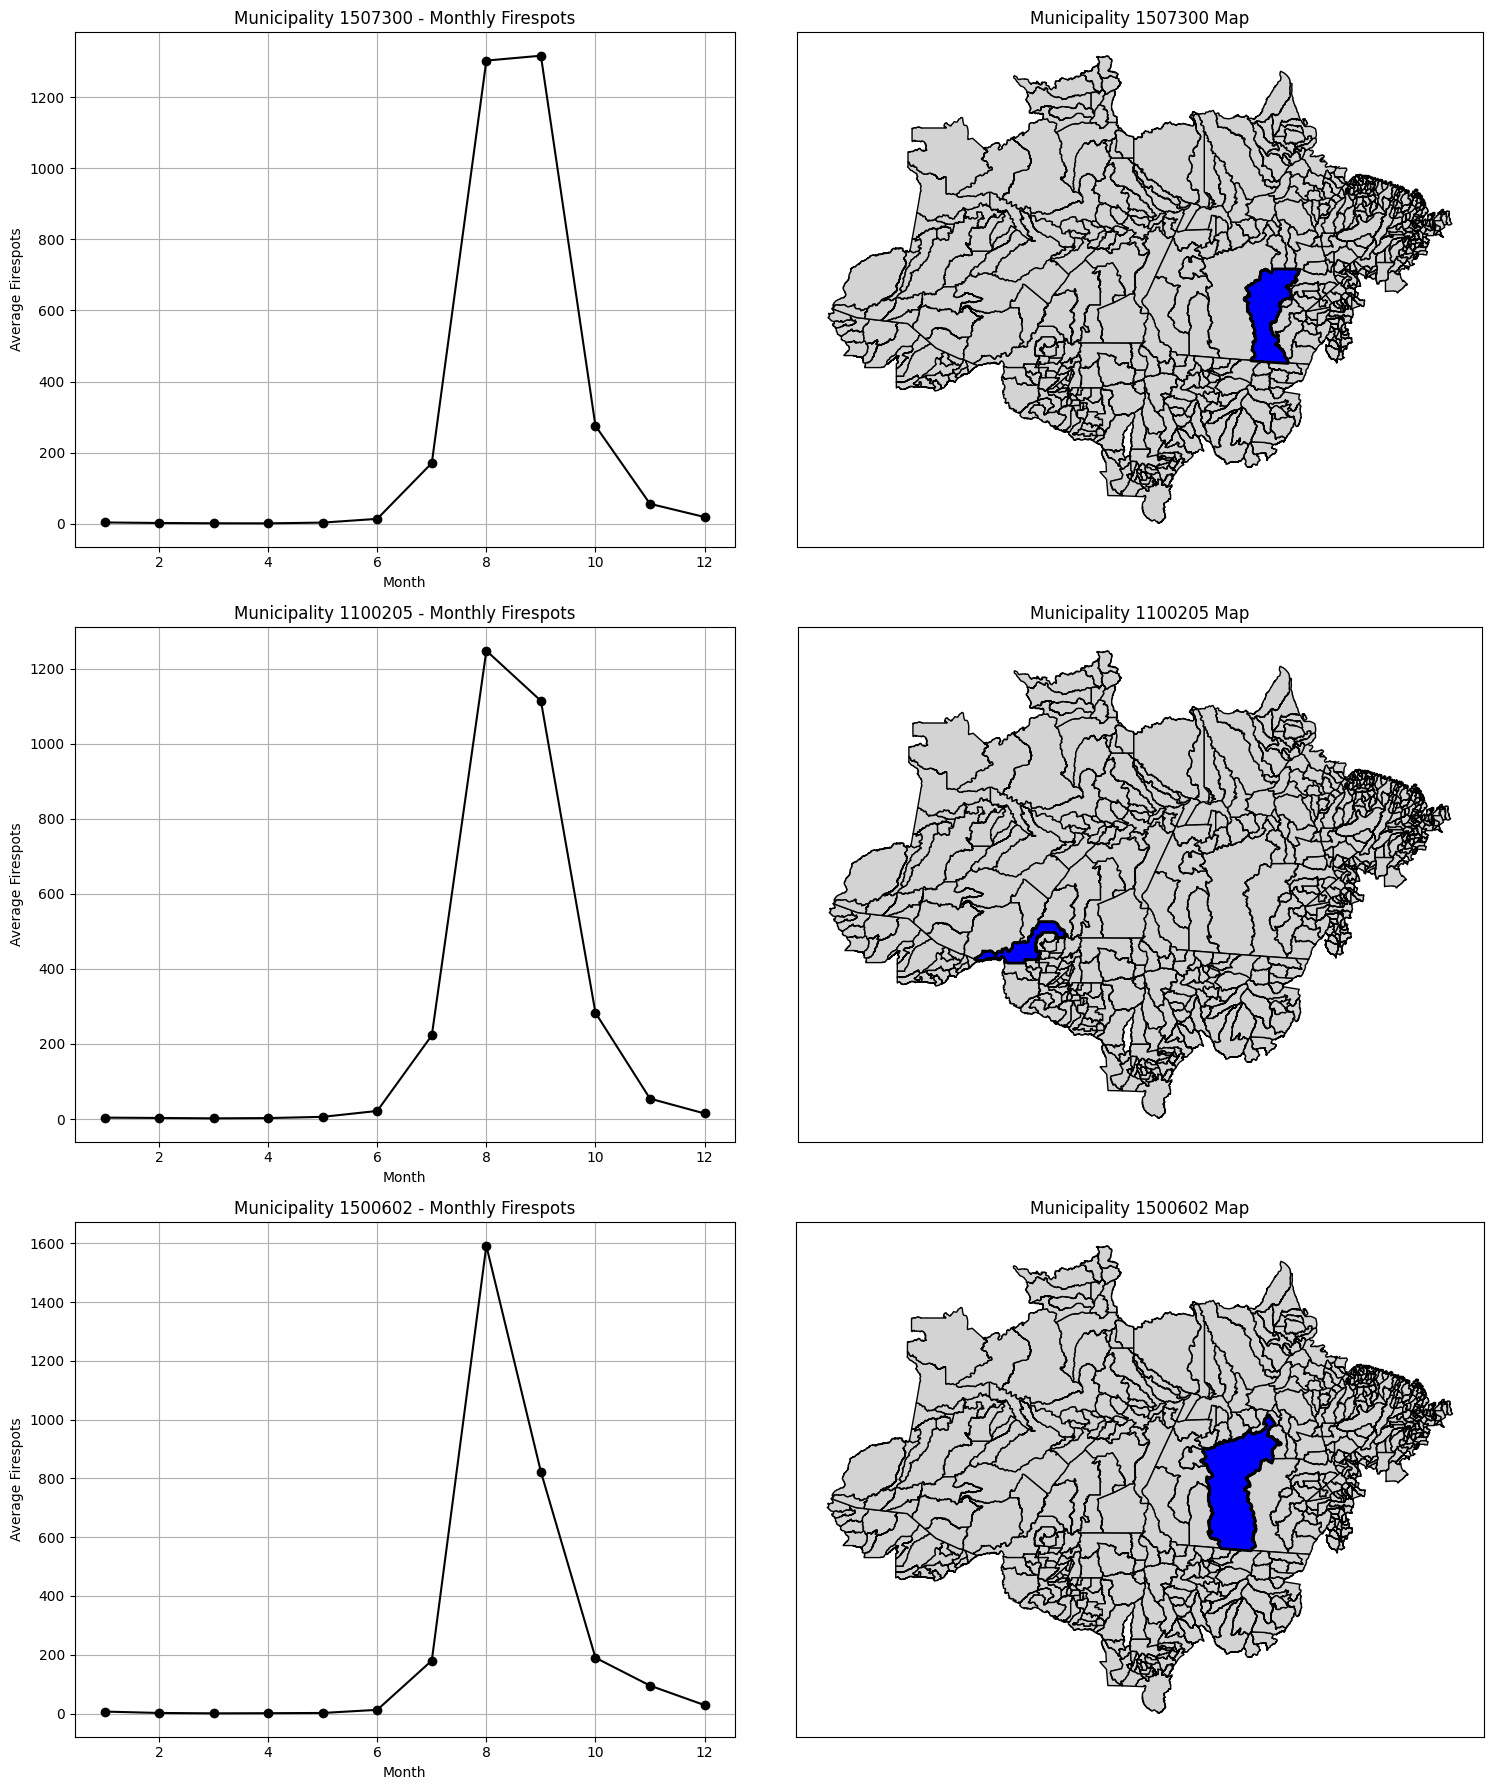

In [42]:
from matplotlib import gridspec

# Step 1: Identify the top 9 municipalities with the highest average firespots
top_municipalities = (
    result.groupby('vec_Munic')['vec_FS'].mean().nlargest(3).index
)

# Step 2: Load geospatial data
gdf = geobr.read_municipality(year=2020)

# Step 3: Filter geospatial data for the unique municipalities in the 'result' dataframe
unique_municipalities = result['vec_Munic'].unique()
gdf_filtered = gdf[gdf['code_muni'].isin(unique_municipalities)]

# Step 4: Filter geospatial data for the top 9 municipalities
top_municipalities_data = gdf_filtered[gdf_filtered['code_muni'].isin(top_municipalities)]

# Step 5: Create a plot with subplots for each municipality
fig = plt.figure(figsize=(16, len(top_municipalities)*6), facecolor='white')
gs = gridspec.GridSpec(len(top_municipalities), 2, width_ratios=[3, 4])  # Wider left side for the line plot

for i, mun in enumerate(top_municipalities):
    # Filter data for the current municipality
    municipality_data = result[result['vec_Munic'] == mun]
    
    # Left side: Line plot for the monthly average firespots
    axis_left = fig.add_subplot(gs[i, 0])
    axis_left.plot(municipality_data['vec_Month'], municipality_data['vec_FS'], marker='o', color='black')
    axis_left.set_title(f'Municipality {mun} - Monthly Firespots', fontsize=12)
    axis_left.set_xlabel('Month')
    axis_left.set_ylabel('Average Firespots')
    axis_left.grid(True)

    # Right side: Plot the map with all municipalities and highlight the current municipality in blue
    axis_right = fig.add_subplot(gs[i, 1])
    
    # Plot the map with filtered municipalities
    gdf_filtered.plot(ax=axis_right, color='lightgrey', edgecolor='k')
    
    # Highlight the specific municipality in blue
    top_municipalities_data[top_municipalities_data['code_muni'] == mun].plot(
        ax=axis_right, color='blue', edgecolor='k', linewidth=2
    )

    # Set title and remove axes
    axis_right.set_title(f'Municipality {mun} Map', fontsize=12)
    axis_right.set_xticks([])
    axis_right.set_yticks([])

# Step 6: Adjust layout
plt.tight_layout()
plt.show()

In [43]:
month_data = result[result['vec_Month'] == 1]
month_data["v"]

KeyError: 'v'

In [57]:
import pandas as pd

# Define the data as a nested list
data = [
    [3.71973027e+02, 5.44427043e+02, 3.80056205e+04, 1.17568311e+05, 2.06363971e+03],
    [5.44427043e+02, 7.96834136e+02, 5.56257743e+04, 1.72075294e+05, 3.02038369e+03],
    [3.80056205e+04, 5.56257743e+04, 3.88315036e+06, 1.20123135e+07, 2.10848373e+05],
    [1.17568311e+05, 1.72075294e+05, 1.20123135e+07, 3.71594356e+07, 6.52247925e+05],
    [2.06363971e+03, 3.02038369e+03, 2.10848373e+05, 6.52247925e+05, 1.14487034e+04]
]

# Create a DataFrame
df = pd.DataFrame(data)

# Print the DataFrame
df.to_latex()

'\\begin{tabular}{lrrrrr}\n\\toprule\n & 0 & 1 & 2 & 3 & 4 \\\\\n\\midrule\n0 & 371.973027 & 544.427043 & 38005.620500 & 117568.311000 & 2063.639710 \\\\\n1 & 544.427043 & 796.834136 & 55625.774300 & 172075.294000 & 3020.383690 \\\\\n2 & 38005.620500 & 55625.774300 & 3883150.360000 & 12012313.500000 & 210848.373000 \\\\\n3 & 117568.311000 & 172075.294000 & 12012313.500000 & 37159435.600000 & 652247.925000 \\\\\n4 & 2063.639710 & 3020.383690 & 210848.373000 & 652247.925000 & 11448.703400 \\\\\n\\bottomrule\n\\end{tabular}\n'